In [1]:
import numpy as np
import glob, os
import xarray as xr
import time, datetime, calendar, pytz
from scipy import fftpack
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
regions = ['indian_ocean', 'maritime_continent', 'wpacific', 'africa', 'amazon', 'tropics']

startdate = '20200201'
enddate = '20200228'
test = ''
# rootdir = '/Users/feng045/data/e3sm/scream/'
# rootdir = '/global/cscratch1/sd/feng045/E3SM/SCREAMv0/'
# rootdir = '/global/cfs/cdirs/m1867/zfeng/E3SM/SCREAMv0/'
rootdir = '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/'
obsfiles = []
e3smfiles = []
for ii in regions:
#     print(ii)
    obsfiles.append(f'{rootdir}gpm_1200x3600/stats{test}/mcs_rainrate_hist_{startdate}_{enddate}_{ii}.nc')
    e3smfiles.append(f'{rootdir}mcs_1200x3600/stats{test}/mcs_rainrate_hist_{startdate}_{enddate}_{ii}.nc')

figdir = f'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures{test}/'
# figdir = f'/Users/feng045/results/E3SM/SCREAMv0/mcs_1200x3600/figures{test}/'
os.makedirs(figdir, exist_ok=True)

In [3]:
obsfiles, e3smfiles

(['/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_indian_ocean.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_maritime_continent.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_wpacific.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_africa.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_amazon.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/gpm_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_tropics.nc'],
 ['/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/stats/mcs_rainrate_hist_20200201_20200228_indian_ocean.nc',
  '/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/stats/mcs_rainrate_hist_20

In [4]:
dsobs0 = xr.open_dataset(obsfiles[0])
dsobs1 = xr.open_dataset(obsfiles[1])
dsobs2 = xr.open_dataset(obsfiles[2])
dsobs3 = xr.open_dataset(obsfiles[3])
dsobs4 = xr.open_dataset(obsfiles[4])
dsobs5 = xr.open_dataset(obsfiles[5])
lon_box = {}
lon_box[regions[0]] =  dsobs0.attrs['lonbox']
lon_box[regions[1]] =  dsobs1.attrs['lonbox']
lon_box[regions[2]] =  dsobs2.attrs['lonbox']
lon_box[regions[3]] =  dsobs3.attrs['lonbox']
lon_box[regions[4]] =  dsobs4.attrs['lonbox']
lon_box[regions[5]] =  dsobs5.attrs['lonbox']
lat_box = {}
lat_box[regions[0]] =  dsobs0.attrs['latbox']
lat_box[regions[1]] =  dsobs1.attrs['latbox']
lat_box[regions[2]] =  dsobs2.attrs['latbox']
lat_box[regions[3]] =  dsobs3.attrs['latbox']
lat_box[regions[4]] =  dsobs4.attrs['latbox']
lat_box[regions[5]] =  dsobs5.attrs['latbox']
print(lon_box)
print(lat_box)

{'indian_ocean': array([40., 95.]), 'maritime_continent': array([ 95., 150.]), 'wpacific': array([150., 230.]), 'africa': array([10., 40.]), 'amazon': array([285., 320.]), 'tropics': array([  0., 360.])}
{'indian_ocean': array([-25.,  15.]), 'maritime_continent': array([-20.,  15.]), 'wpacific': array([-30.,  15.]), 'africa': array([-20.,   5.]), 'amazon': array([-20.,   0.]), 'tropics': array([-20.,  15.])}


In [5]:
# Change lon bounds from [0~360] to [-180~+180] for plotting purpose
for reg in regions:
    if (lon_box[reg][0] > 180) & (lon_box[reg][1] > 180):
        lon_box[reg] = ((np.array([lon_box[reg][0], lon_box[reg][1]]) - 180) % 360) - 180
    else:
        lon_box[reg] = np.array([lon_box[reg][0], lon_box[reg][1]])
lon_box

{'indian_ocean': array([40., 95.]),
 'maritime_continent': array([ 95., 150.]),
 'wpacific': array([150., 230.]),
 'africa': array([10., 40.]),
 'amazon': array([-75., -40.]),
 'tropics': array([  0., 360.])}

In [6]:
dsobs = xr.open_mfdataset(obsfiles, concat_dim='region', combine='nested')
dsobs['region'] = regions
dsobs

<xarray.Dataset>
Dimensions:          (bins: 199, region: 6)
Coordinates:
  * bins             (bins) int64 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * region           (region) <U18 'indian_ocean' ... 'tropics'
Data variables:
    total_land       (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_land         (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_land         (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_land   (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    total_ocean      (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_ocean        (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_ocean        (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_ocean  (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
Attributes:
    title:       Precipitation PDF by types
    lonbox:      [40. 95.]
    latbox:      [-25.  15.]
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Feb 16 15:03:32 2022

In [7]:
dsm1 = xr.open_mfdataset(e3smfiles, concat_dim='region', combine='nested')
dsm1['region'] = regions
dsm1

<xarray.Dataset>
Dimensions:          (bins: 199, region: 6)
Coordinates:
  * bins             (bins) int64 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * region           (region) <U18 'indian_ocean' ... 'tropics'
Data variables:
    total_land       (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_land         (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_land         (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_land   (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    total_ocean      (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_ocean        (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_ocean        (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_ocean  (region, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
Attributes:
    title:       Precipitation PDF by types
    lonbox:      [40. 95.]
    latbox:      [-25.  15.]
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Feb 16 15:04:03 2022

In [8]:
def plot_pdf_6panels(bins, data_obs, data_m1,   
                     titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                     map_extent, bounds, inset_param, figname):
    
    region = 'maritime_continent'
#     data_obs = [dsobs['total_ocean'].sel(region=region), dsobs['total_ocean'].sel(region=region)]

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[10,8], dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,3):
        for col in range(0,2): 
            ax = axes[row][col]
            ax.plot(bins, data_obs[row][col], colors['obs'], lw=3, label=legends['obs'])
            ax.plot(bins, data_m1[row][col], colors['m1'], lw=3, label=legends['m1'])

            ax.legend(fontsize=11)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[col])
#             ax.set_xticks(xticks)
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales)
            ax.set_yscale(yscales)

            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=bounds[0], maxx=bounds[1], miny=bounds[2], maxy=bounds[3])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

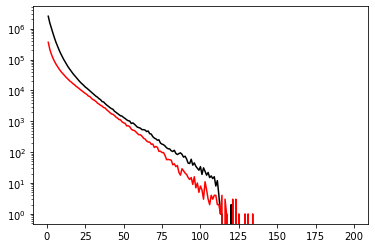

In [9]:
region = 'wpacific'
rrbins = dsobs['bins']
yyobs = dsobs.mcs_ocean.sel(region=region)
yym1 = dsm1.mcs_ocean.sel(region=region)
fig, axes = plt.subplots(1,1)
ax = axes
ax.plot(rrbins, yyobs, color='k')
ax.plot(rrbins, yym1, color='r')
xscales = 'linear'
yscales = 'log'
ax.set_xscale(xscales)
ax.set_yscale(yscales)

<ipython-input-8-48464c3e215f>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


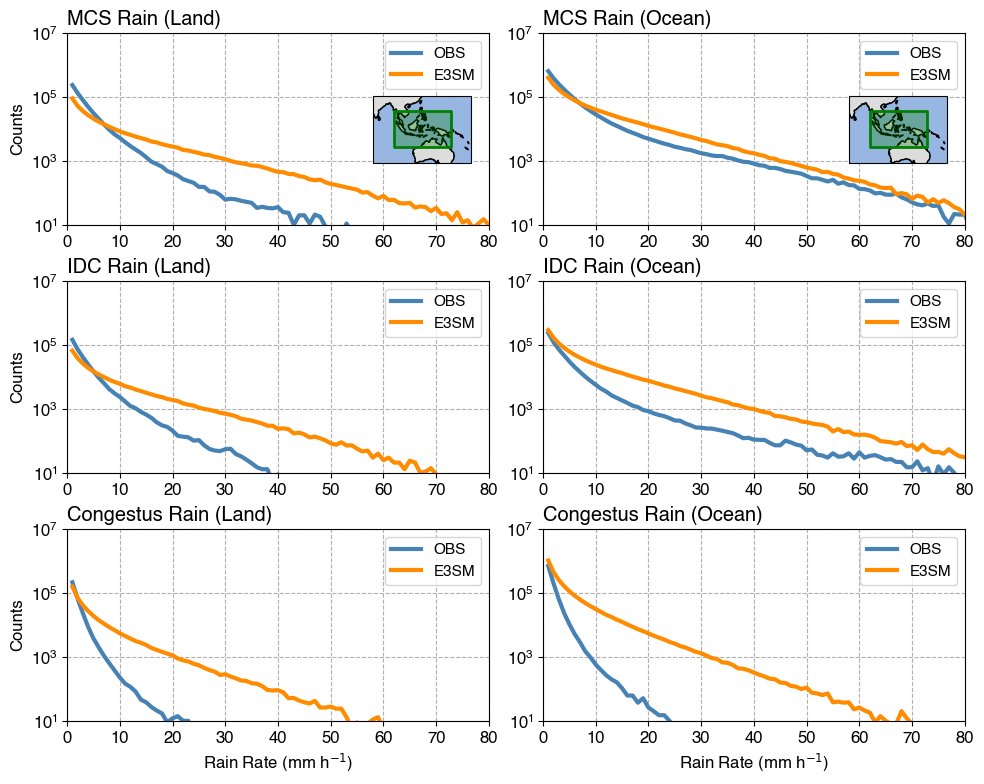

In [10]:
region = 'maritime_continent'
xbins = dsobs['bins']
data_obs = [[dsobs.mcs_land.sel(region=region), dsobs.mcs_ocean.sel(region=region)],
            [dsobs.idc_land.sel(region=region), dsobs.idc_ocean.sel(region=region)],
            [dsobs.congestus_land.sel(region=region), dsobs.congestus_ocean.sel(region=region)]]
data_m1 = [[dsm1.mcs_land.sel(region=region), dsm1.mcs_ocean.sel(region=region)],
            [dsm1.idc_land.sel(region=region), dsm1.idc_ocean.sel(region=region)],
            [dsm1.congestus_land.sel(region=region), dsm1.congestus_ocean.sel(region=region)]]
titles = [['MCS Rain (Land)', 'MCS Rain (Ocean)'],
          ['IDC Rain (Land)', 'IDC Rain (Ocean)'],
          ['Congestus Rain (Land)', 'Congestus Rain (Ocean)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Counts', '']
xlims = [0, 80]
ylims = [[10,1e7],[10,1e7],[10,1e7]]
xscales = 'linear'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'E3SM'}

bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
inset_param = {'width':'30%', 'height':'35%', 'loc':'center right', 'borderpad':0.2}
figname = f'{figdir}rainrate_hist_mcs_idc_congestus_landocean_{region}.png'
        
fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname)

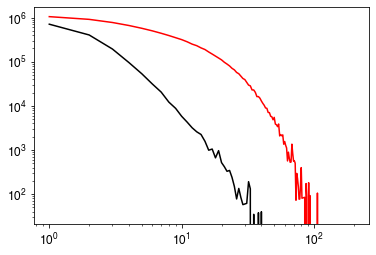

In [11]:
region = 'maritime_continent'
# yy_obs = dsobs.mcs_ocean.sel(region=region) * rrbins
# yy_m1 = dsm1.mcs_ocean.sel(region=region) * rrbins
yy_obs = dsobs.congestus_ocean.sel(region=region) * rrbins
yy_m1 = dsm1.congestus_ocean.sel(region=region) * rrbins
fig, axes = plt.subplots(1,1)
ax = axes
ax.plot(xbins, yy_obs, color='k')
ax.plot(xbins, yy_m1, color='r')
xscales = 'log'
yscales = 'log'
ax.set_xscale(xscales)
ax.set_yscale(yscales)

<ipython-input-8-48464c3e215f>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


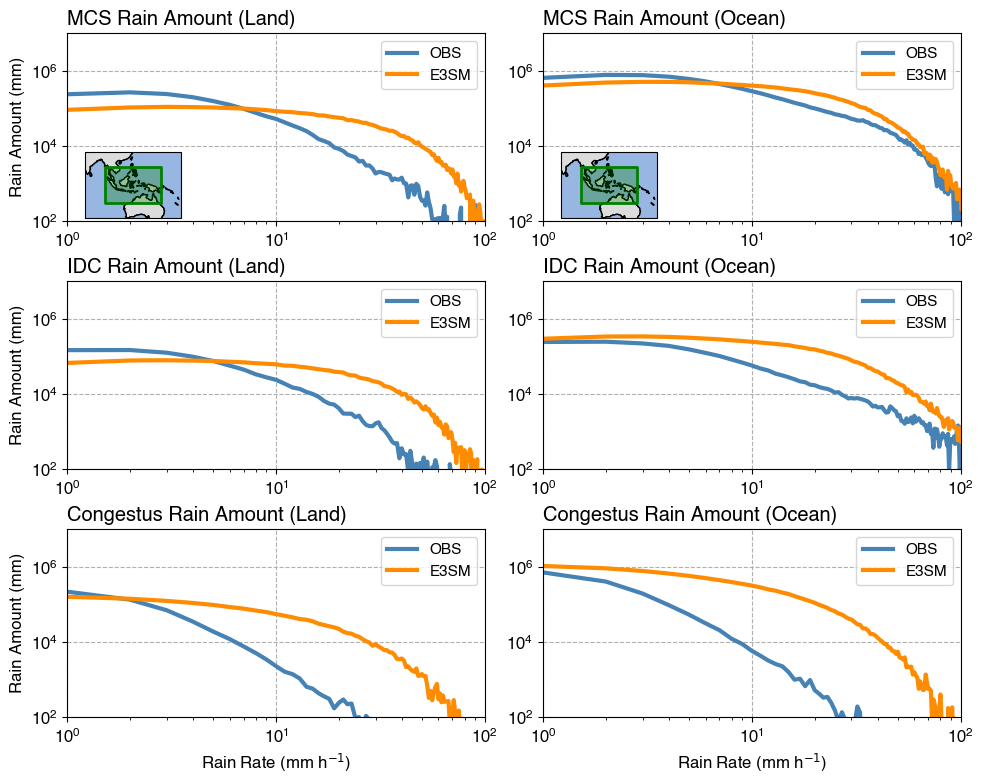

In [12]:
region = 'maritime_continent'

mcsamt_land_hist_obs = (dsobs.mcs_land.sel(region=region) ) * rrbins
mcsamt_ocean_hist_obs = (dsobs.mcs_ocean.sel(region=region) ) * rrbins
idcamt_land_hist_obs = (dsobs.idc_land.sel(region=region) ) * rrbins
idcamt_ocean_hist_obs = (dsobs.idc_ocean.sel(region=region) ) * rrbins
congamt_land_hist_obs = (dsobs.congestus_land.sel(region=region) ) * rrbins
congamt_ocean_hist_obs = (dsobs.congestus_ocean.sel(region=region) ) * rrbins

mcsamt_land_hist_m1 = (dsm1.mcs_land.sel(region=region) ) * rrbins
mcsamt_ocean_hist_m1 = (dsm1.mcs_ocean.sel(region=region) ) * rrbins
idcamt_land_hist_m1 = (dsm1.idc_land.sel(region=region) ) * rrbins
idcamt_ocean_hist_m1 = (dsm1.idc_ocean.sel(region=region) ) * rrbins
congamt_land_hist_m1 = (dsm1.congestus_land.sel(region=region) ) * rrbins
congamt_ocean_hist_m1 = (dsm1.congestus_ocean.sel(region=region) ) * rrbins

xbins = dsobs['bins']
data_obs = [[mcsamt_land_hist_obs, mcsamt_ocean_hist_obs],
            [idcamt_land_hist_obs, idcamt_ocean_hist_obs],
            [congamt_land_hist_obs, congamt_ocean_hist_obs]]
data_m1 = [[mcsamt_land_hist_m1, mcsamt_ocean_hist_m1],
            [idcamt_land_hist_m1, idcamt_ocean_hist_m1],
            [congamt_land_hist_m1, congamt_ocean_hist_m1]]
titles = [['MCS Rain Amount (Land)', 'MCS Rain Amount (Ocean)'],
          ['IDC Rain Amount (Land)', 'IDC Rain Amount (Ocean)'],
          ['Congestus Rain Amount (Land)', 'Congestus Rain Amount (Ocean)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Rain Amount (mm)', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'E3SM'}

bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainamount_hist_mcs_idc_congestus_landocean_{region}.png'
        
fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname)

<ipython-input-8-48464c3e215f>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


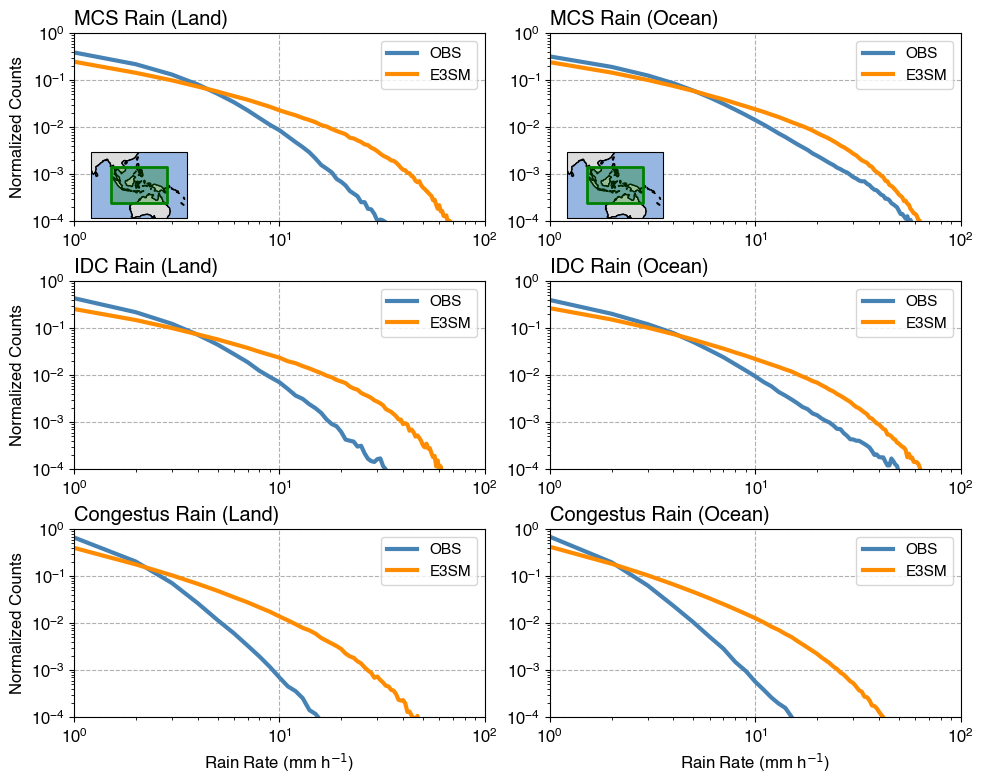

In [13]:
region = 'maritime_continent'
xbins = dsobs['bins']
data_obs = [[dsobs.mcs_land.sel(region=region)/np.nansum(dsobs.mcs_land.sel(region=region)), 
             dsobs.mcs_ocean.sel(region=region)/np.nansum(dsobs.mcs_ocean.sel(region=region))],
            [dsobs.idc_land.sel(region=region)/np.nansum(dsobs.idc_land.sel(region=region)), 
             dsobs.idc_ocean.sel(region=region)/np.nansum(dsobs.idc_ocean.sel(region=region))],
            [dsobs.congestus_land.sel(region=region)/np.nansum(dsobs.congestus_land.sel(region=region)), 
             dsobs.congestus_ocean.sel(region=region)/np.nansum(dsobs.congestus_ocean.sel(region=region))]]
data_m1 = [[dsm1.mcs_land.sel(region=region)/np.nansum(dsm1.mcs_land.sel(region=region)), 
             dsm1.mcs_ocean.sel(region=region)/np.nansum(dsm1.mcs_ocean.sel(region=region))],
            [dsm1.idc_land.sel(region=region)/np.nansum(dsm1.idc_land.sel(region=region)), 
             dsm1.idc_ocean.sel(region=region)/np.nansum(dsm1.idc_ocean.sel(region=region))],
            [dsm1.congestus_land.sel(region=region)/np.nansum(dsm1.congestus_land.sel(region=region)), 
             dsm1.congestus_ocean.sel(region=region)/np.nansum(dsm1.congestus_ocean.sel(region=region))]]
titles = [['MCS Rain (Land)', 'MCS Rain (Ocean)'],
          ['IDC Rain (Land)', 'IDC Rain (Ocean)'],
          ['Congestus Rain (Land)', 'Congestus Rain (Ocean)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Normalized Counts', '']
# xlims = [0, 80]
xlims = [1, 100]
ylims = [[1e-4,1],[1e-4,1],[1e-4,1]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'E3SM'}

bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_mcs_idc_congestus_landocean_{region}.png'
        
fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname)

In [14]:
def plot_pdf_mxn(nrow, ncol, bins, data_obs, data_m1,   
                 titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                 map_extent, bounds, inset_param, figname, legend_loc='best', figsize=[12,8]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,nrow):
        for col in range(0,ncol): 
            ax = axes[row][col]
            ax.plot(bins, data_obs[row][col], colors['obs'], lw=3, label=legends['obs'])
            ax.plot(bins, data_m1[row][col], colors['m1'], lw=3, label=legends['m1'])

            if (row==0 & col==0): ax.legend(fontsize=11, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[col])
#             ax.set_xticks(xticks)
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            ax.set_xscale(xscales)
            ax.set_yscale(yscales)

            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent[col], crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=bounds[col][0], maxx=bounds[col][1], miny=bounds[col][2], maxy=bounds[col][3])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


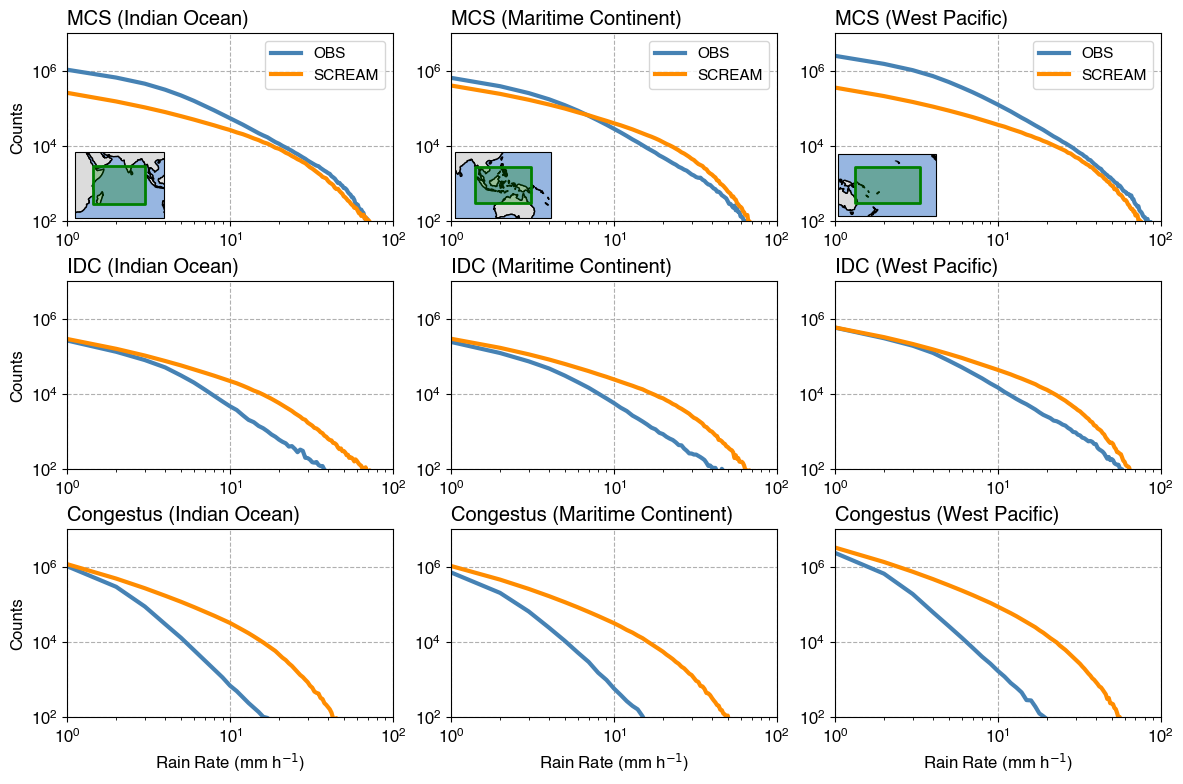

In [15]:
reg = ['indian_ocean','maritime_continent', 'wpacific']
xbins = dsobs['bins']
data_obs = [[dsobs.mcs_ocean.sel(region=reg[0]), dsobs.mcs_ocean.sel(region=reg[1]), dsobs.mcs_ocean.sel(region=reg[2])],
            [dsobs.idc_ocean.sel(region=reg[0]), dsobs.idc_ocean.sel(region=reg[1]), dsobs.idc_ocean.sel(region=reg[2])],
            [dsobs.congestus_ocean.sel(region=reg[0]), dsobs.congestus_ocean.sel(region=reg[1]), dsobs.congestus_ocean.sel(region=reg[2])]]
data_m1 = [[dsm1.mcs_ocean.sel(region=reg[0]), dsm1.mcs_ocean.sel(region=reg[1]), dsm1.mcs_ocean.sel(region=reg[2])],
            [dsm1.idc_ocean.sel(region=reg[0]), dsm1.idc_ocean.sel(region=reg[1]), dsm1.idc_ocean.sel(region=reg[2])],
            [dsm1.congestus_ocean.sel(region=reg[0]), dsm1.congestus_ocean.sel(region=reg[1]), dsm1.congestus_ocean.sel(region=reg[2])]]
titles = [['MCS (Indian Ocean)', 'MCS (Maritime Continent)', 'MCS (West Pacific)'],
          ['IDC (Indian Ocean)', 'IDC (Maritime Continent)', 'IDC (West Pacific)'],
          ['Congestus (Indian Ocean)', 'Congestus (Maritime Continent)', 'Congestus (West Pacific)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Counts', '', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-20,bounds[0][1]+20,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-20,bounds[1][1]+20,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-20,bounds[2][1]+20,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_mcs_idc_congestus_3ocean.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='best')

In [16]:
lon_box

{'indian_ocean': array([40., 95.]),
 'maritime_continent': array([ 95., 150.]),
 'wpacific': array([150., 230.]),
 'africa': array([10., 40.]),
 'amazon': array([-75., -40.]),
 'tropics': array([  0., 360.])}

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


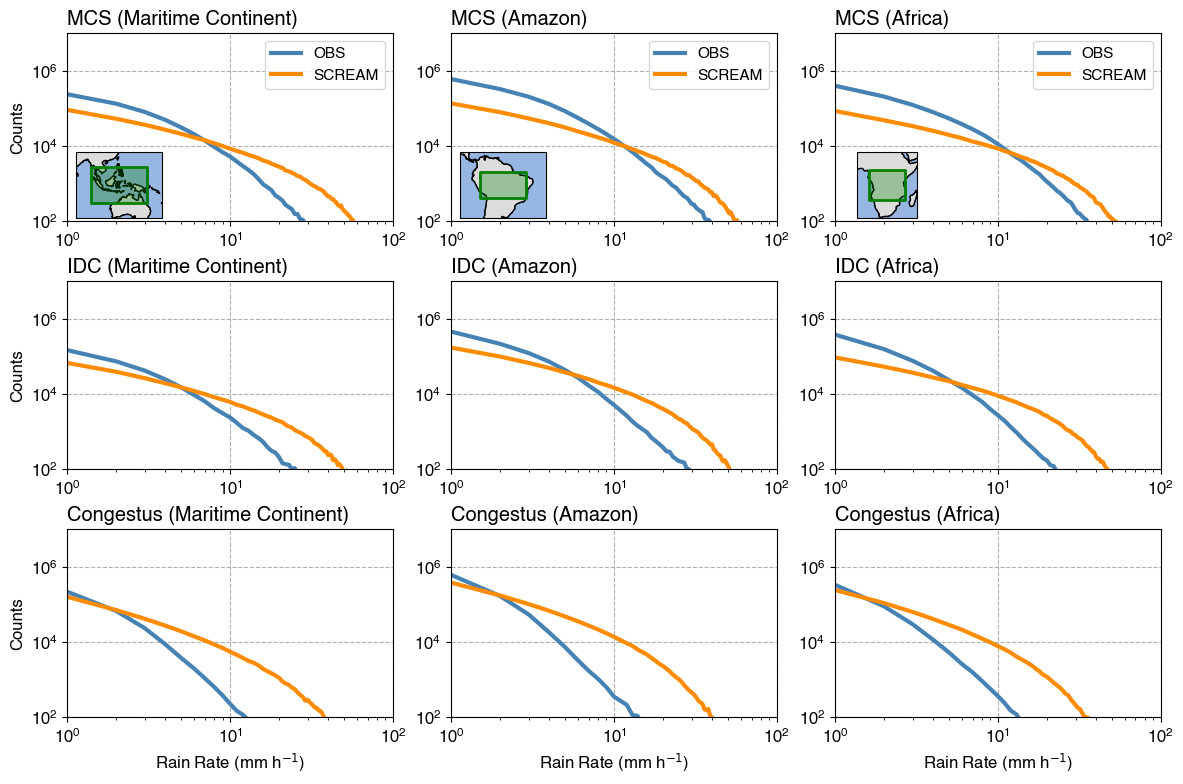

In [17]:
reg = ['maritime_continent','amazon','africa']
xbins = dsobs['bins']
data_obs = [[dsobs.mcs_land.sel(region=reg[0]), dsobs.mcs_land.sel(region=reg[1]), dsobs.mcs_land.sel(region=reg[2])],
            [dsobs.idc_land.sel(region=reg[0]), dsobs.idc_land.sel(region=reg[1]), dsobs.idc_land.sel(region=reg[2])],
            [dsobs.congestus_land.sel(region=reg[0]), dsobs.congestus_land.sel(region=reg[1]), dsobs.congestus_land.sel(region=reg[2])]]
data_m1 = [[dsm1.mcs_land.sel(region=reg[0]), dsm1.mcs_land.sel(region=reg[1]), dsm1.mcs_land.sel(region=reg[2])],
            [dsm1.idc_land.sel(region=reg[0]), dsm1.idc_land.sel(region=reg[1]), dsm1.idc_land.sel(region=reg[2])],
            [dsm1.congestus_land.sel(region=reg[0]), dsm1.congestus_land.sel(region=reg[1]), dsm1.congestus_land.sel(region=reg[2])]]
titles = [['MCS (Maritime Continent)', 'MCS (Amazon)', 'MCS (Africa)'],
          ['IDC (Maritime Continent)', 'IDC (Amazon)', 'IDC (Africa)'],
          ['Congestus (Maritime Continent)', 'Congestus (Amazon)', 'Congestus (Africa)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Counts', '', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-15,bounds[0][1]+15,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-15,bounds[1][1]+15,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-10,bounds[2][1]+10,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_mcs_idc_congestus_3land.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='best')

In [18]:
# Calculate cumulative histogram of rain amount by rain rate
totamt_cumhist_ocean_obs = (dsobs.total_ocean * rrbins).cumsum(dim='bins')
totamt_cumhist_ocean_m1 = (dsm1.total_ocean * rrbins).cumsum(dim='bins')
mcsamt_cumhist_ocean_obs = (dsobs.mcs_ocean * rrbins).cumsum(dim='bins') 
mcsamt_cumhist_ocean_m1 = (dsm1.mcs_ocean * rrbins).cumsum(dim='bins')
idcamt_cumhist_ocean_obs = (dsobs.idc_ocean * rrbins).cumsum(dim='bins') 
idcamt_cumhist_ocean_m1 = (dsm1.idc_ocean * rrbins).cumsum(dim='bins')
congamt_cumhist_ocean_obs = (dsobs.congestus_ocean * rrbins).cumsum(dim='bins') 
congamt_cumhist_ocean_m1 = (dsm1.congestus_ocean * rrbins).cumsum(dim='bins')
# Normalized by total rain amount for each type
norm_mcsamt_cumhist_ocean_obs = mcsamt_cumhist_ocean_obs / (dsobs.mcs_ocean * rrbins).sum(dim='bins')
norm_mcsamt_cumhist_ocean_m1 = mcsamt_cumhist_ocean_m1 / (dsm1.mcs_ocean * rrbins).sum(dim='bins')
norm_idcamt_cumhist_ocean_obs = idcamt_cumhist_ocean_obs / (dsobs.idc_ocean * rrbins).sum(dim='bins')
norm_idcamt_cumhist_ocean_m1 = idcamt_cumhist_ocean_m1 / (dsm1.idc_ocean * rrbins).sum(dim='bins')
norm_congamt_cumhist_ocean_obs = congamt_cumhist_ocean_obs / (dsobs.congestus_ocean * rrbins).sum(dim='bins')
norm_congamt_cumhist_ocean_m1 = congamt_cumhist_ocean_m1 / (dsm1.congestus_ocean * rrbins).sum(dim='bins')

# Calculate cumulative histogram of rain amount by rain rate
totamt_cumhist_land_obs = (dsobs.total_land * rrbins).cumsum(dim='bins')
totamt_cumhist_land_m1 = (dsm1.total_land * rrbins).cumsum(dim='bins')
mcsamt_cumhist_land_obs = (dsobs.mcs_land * rrbins).cumsum(dim='bins') 
mcsamt_cumhist_land_m1 = (dsm1.mcs_land * rrbins).cumsum(dim='bins')
idcamt_cumhist_land_obs = (dsobs.idc_land * rrbins).cumsum(dim='bins') 
idcamt_cumhist_land_m1 = (dsm1.idc_land * rrbins).cumsum(dim='bins')
congamt_cumhist_land_obs = (dsobs.congestus_land * rrbins).cumsum(dim='bins') 
congamt_cumhist_land_m1 = (dsm1.congestus_land * rrbins).cumsum(dim='bins')
# Normalized by total rain amount for each type
norm_mcsamt_cumhist_land_obs = mcsamt_cumhist_land_obs / (dsobs.mcs_land * rrbins).sum(dim='bins')
norm_mcsamt_cumhist_land_m1 = mcsamt_cumhist_land_m1 / (dsm1.mcs_land * rrbins).sum(dim='bins')
norm_idcamt_cumhist_land_obs = idcamt_cumhist_land_obs / (dsobs.idc_land * rrbins).sum(dim='bins')
norm_idcamt_cumhist_land_m1 = idcamt_cumhist_land_m1 / (dsm1.idc_land * rrbins).sum(dim='bins')
norm_congamt_cumhist_land_obs = congamt_cumhist_land_obs / (dsobs.congestus_land * rrbins).sum(dim='bins')
norm_congamt_cumhist_land_m1 = congamt_cumhist_land_m1 / (dsm1.congestus_land * rrbins).sum(dim='bins')

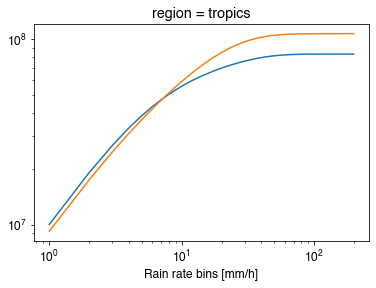

In [19]:
# totamt_cumhist_ocean_obs = (dsobs.total_ocean * rrbins).cumsum(dim='bins').sel(region='tropics')
# totamt_cumhist_ocean_m1 = (dsm1.total_ocean * rrbins).cumsum(dim='bins').sel(region='tropics')
totamt_cumhist_ocean_obs.sel(region='tropics').plot()
totamt_cumhist_ocean_m1.sel(region='tropics').plot()
plt.xscale('log')
plt.yscale('log')

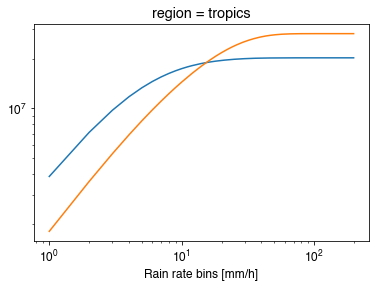

In [20]:
totamt_cumhist_land_obs.sel(region='tropics').plot()
totamt_cumhist_land_m1.sel(region='tropics').plot()
plt.xscale('log')
plt.yscale('log')

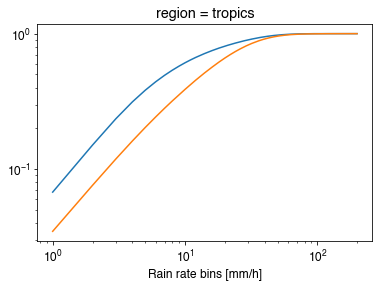

In [21]:
norm_mcsamt_cumhist_ocean_obs.sel(region='tropics').plot()
norm_mcsamt_cumhist_ocean_m1.sel(region='tropics').plot()
plt.yscale('log')
plt.xscale('log')

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


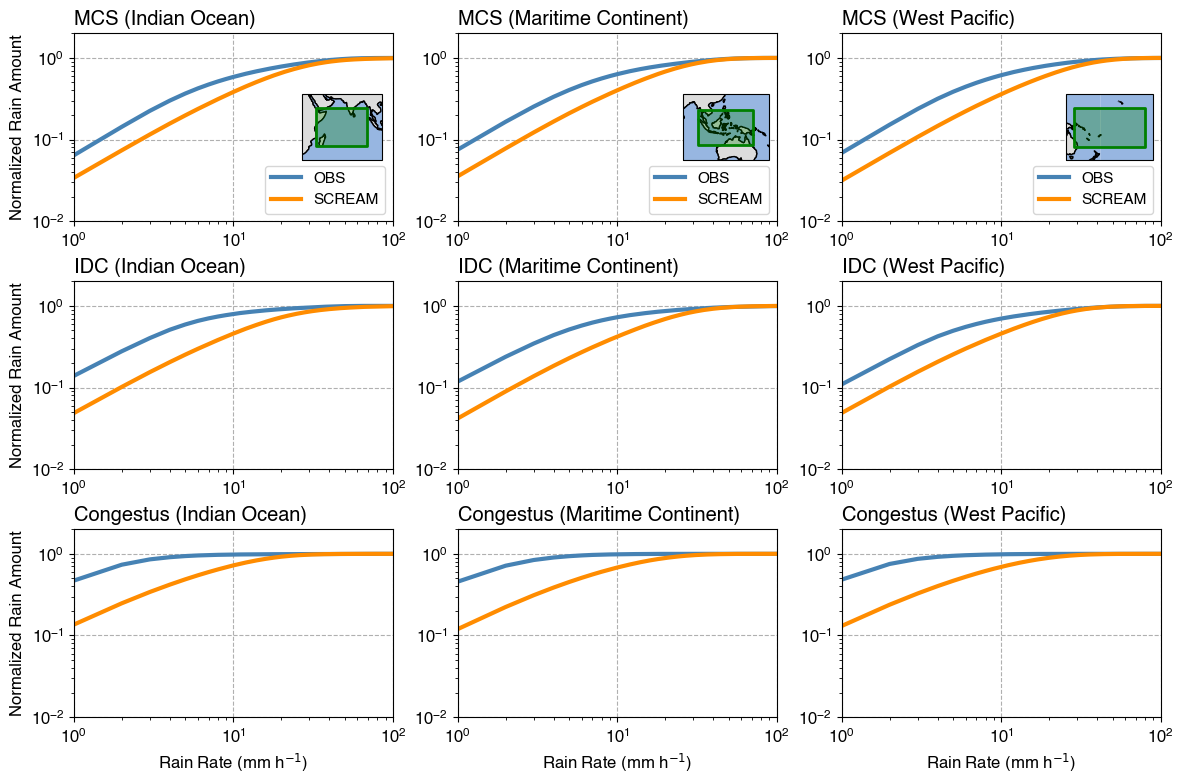

In [22]:
reg = ['indian_ocean','maritime_continent', 'wpacific']
xbins = dsobs['bins']

mcsamt_cumhist_obs = [norm_mcsamt_cumhist_ocean_obs.sel(region=reg[0]), 
                      norm_mcsamt_cumhist_ocean_obs.sel(region=reg[1]), 
                      norm_mcsamt_cumhist_ocean_obs.sel(region=reg[2])]
idcamt_cumhist_obs = [norm_idcamt_cumhist_ocean_obs.sel(region=reg[0]), 
                      norm_idcamt_cumhist_ocean_obs.sel(region=reg[1]), 
                      norm_idcamt_cumhist_ocean_obs.sel(region=reg[2])]
congamt_cumhist_obs = [norm_congamt_cumhist_ocean_obs.sel(region=reg[0]), 
                       norm_congamt_cumhist_ocean_obs.sel(region=reg[1]), 
                       norm_congamt_cumhist_ocean_obs.sel(region=reg[2])]

mcsamt_cumhist_m1 = [norm_mcsamt_cumhist_ocean_m1.sel(region=reg[0]), 
                     norm_mcsamt_cumhist_ocean_m1.sel(region=reg[1]), 
                     norm_mcsamt_cumhist_ocean_m1.sel(region=reg[2])]
idcamt_cumhist_m1 = [norm_idcamt_cumhist_ocean_m1.sel(region=reg[0]), 
                     norm_idcamt_cumhist_ocean_m1.sel(region=reg[1]), 
                     norm_idcamt_cumhist_ocean_m1.sel(region=reg[2])]
congamt_cumhist_m1 = [norm_congamt_cumhist_ocean_m1.sel(region=reg[0]), 
                      norm_congamt_cumhist_ocean_m1.sel(region=reg[1]), 
                      norm_congamt_cumhist_ocean_m1.sel(region=reg[2])]

data_obs = [mcsamt_cumhist_obs, idcamt_cumhist_obs, congamt_cumhist_obs]
data_m1 = [mcsamt_cumhist_m1, idcamt_cumhist_m1, congamt_cumhist_m1]

titles = [['MCS (Indian Ocean)', 'MCS (Maritime Continent)', 'MCS (West Pacific)'],
          ['IDC (Indian Ocean)', 'IDC (Maritime Continent)', 'IDC (West Pacific)'],
          ['Congestus (Indian Ocean)', 'Congestus (Maritime Continent)', 'Congestus (West Pacific)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Normalized Rain Amount', '', '']
xlims = [1, 100]
ylims = [[1e-2,2],[1e-2,2],[1e-2,2]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-15,bounds[0][1]+15,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-15,bounds[1][1]+15,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-10,bounds[2][1]+10,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'center right', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_mcs_idc_congestus_3ocean.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname, legend_loc='lower right')

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


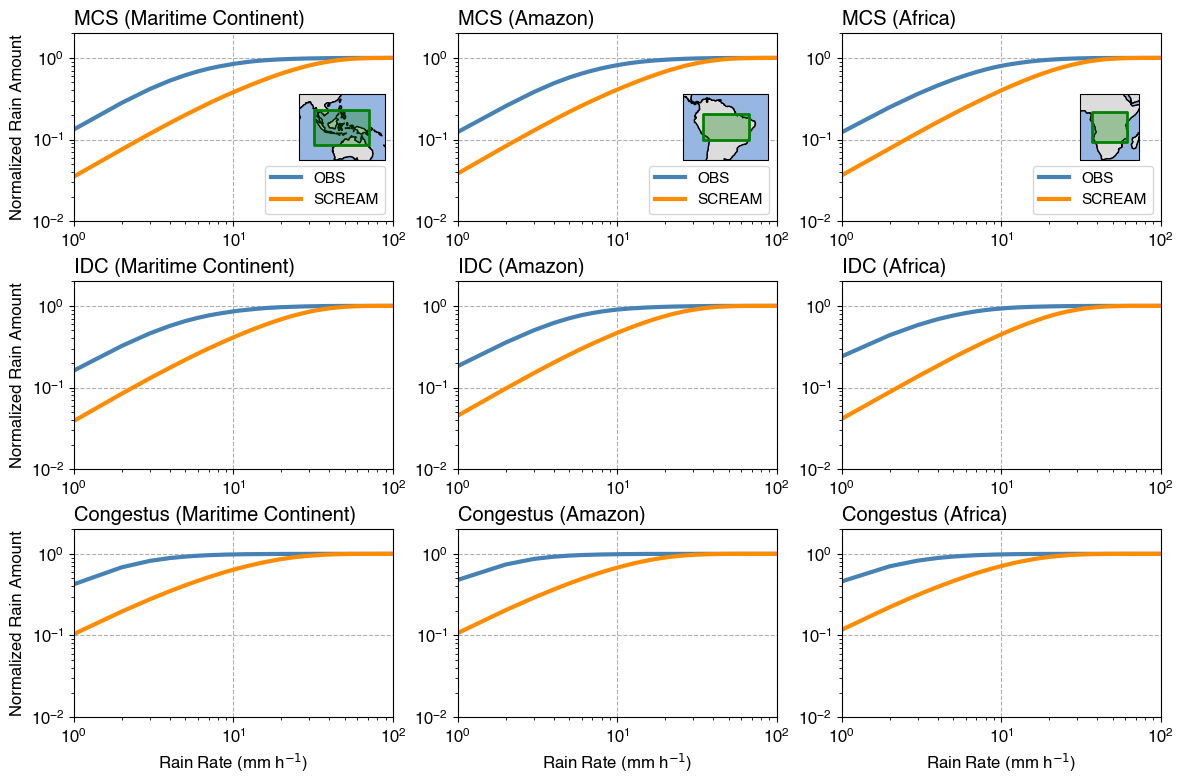

In [23]:
reg = ['maritime_continent','amazon','africa']
xbins = dsobs['bins']

mcsamt_cumhist_obs = [norm_mcsamt_cumhist_land_obs.sel(region=reg[0]), 
                      norm_mcsamt_cumhist_land_obs.sel(region=reg[1]), 
                      norm_mcsamt_cumhist_land_obs.sel(region=reg[2])]
idcamt_cumhist_obs = [norm_idcamt_cumhist_land_obs.sel(region=reg[0]), 
                      norm_idcamt_cumhist_land_obs.sel(region=reg[1]), 
                      norm_idcamt_cumhist_land_obs.sel(region=reg[2])]
congamt_cumhist_obs = [norm_congamt_cumhist_land_obs.sel(region=reg[0]), 
                       norm_congamt_cumhist_land_obs.sel(region=reg[1]), 
                       norm_congamt_cumhist_land_obs.sel(region=reg[2])]

mcsamt_cumhist_m1 = [norm_mcsamt_cumhist_land_m1.sel(region=reg[0]), 
                     norm_mcsamt_cumhist_land_m1.sel(region=reg[1]), 
                     norm_mcsamt_cumhist_land_m1.sel(region=reg[2])]
idcamt_cumhist_m1 = [norm_idcamt_cumhist_land_m1.sel(region=reg[0]), 
                     norm_idcamt_cumhist_land_m1.sel(region=reg[1]), 
                     norm_idcamt_cumhist_land_m1.sel(region=reg[2])]
congamt_cumhist_m1 = [norm_congamt_cumhist_land_m1.sel(region=reg[0]), 
                      norm_congamt_cumhist_land_m1.sel(region=reg[1]), 
                      norm_congamt_cumhist_land_m1.sel(region=reg[2])]

data_obs = [mcsamt_cumhist_obs, idcamt_cumhist_obs, congamt_cumhist_obs]
data_m1 = [mcsamt_cumhist_m1, idcamt_cumhist_m1, congamt_cumhist_m1]

titles = [['MCS (Maritime Continent)', 'MCS (Amazon)', 'MCS (Africa)'],
          ['IDC (Maritime Continent)', 'IDC (Amazon)', 'IDC (Africa)'],
          ['Congestus (Maritime Continent)', 'Congestus (Amazon)', 'Congestus (Africa)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Normalized Rain Amount', '', '']
xlims = [1, 100]
ylims = [[1e-2,2],[1e-2,2],[1e-2,2]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-15,bounds[0][1]+15,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-15,bounds[1][1]+15,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-10,bounds[2][1]+10,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'center right', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_mcs_idc_congestus_3land.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname, legend_loc='lower right')

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


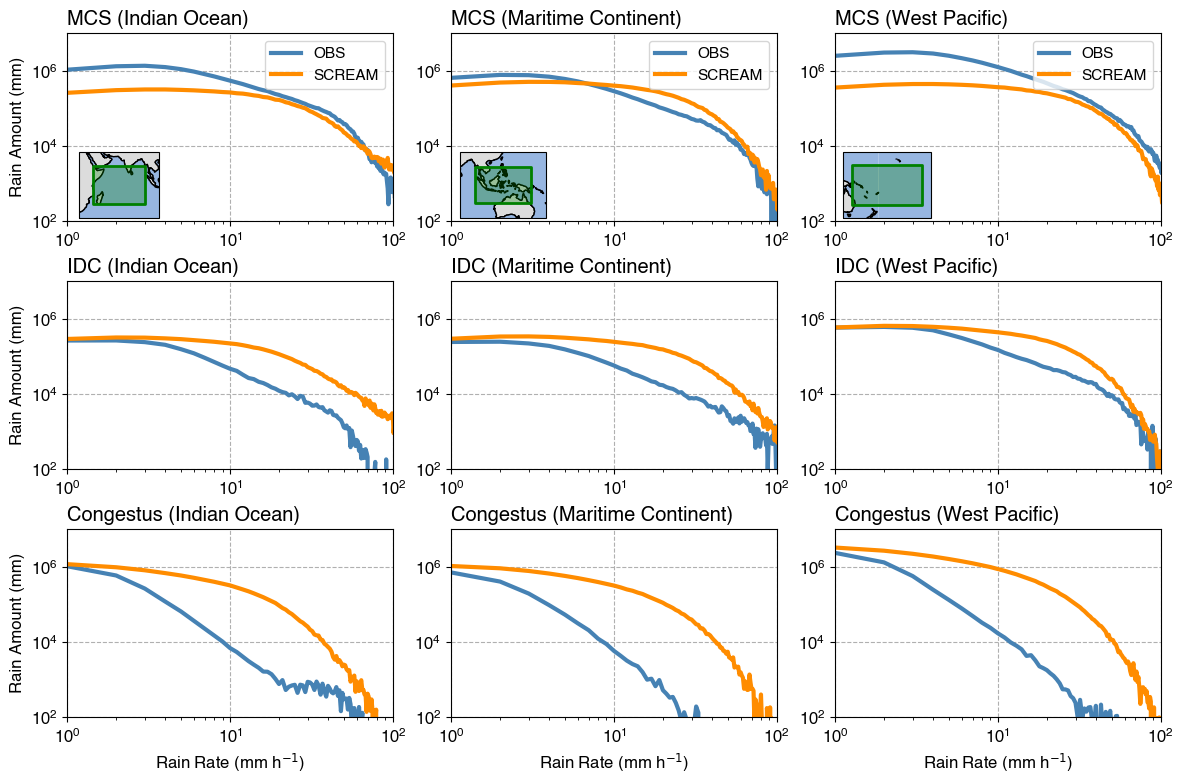

In [24]:
reg = ['indian_ocean','maritime_continent', 'wpacific']
xbins = dsobs['bins']

mcsamt_hist_obs = [(dsobs.mcs_ocean.sel(region=reg[0])) * rrbins, (dsobs.mcs_ocean.sel(region=reg[1])) * rrbins, (dsobs.mcs_ocean.sel(region=reg[2])) * rrbins]
idcamt_hist_obs = [(dsobs.idc_ocean.sel(region=reg[0])) * rrbins, (dsobs.idc_ocean.sel(region=reg[1])) * rrbins, (dsobs.idc_ocean.sel(region=reg[2])) * rrbins]
congamt_hist_obs = [(dsobs.congestus_ocean.sel(region=reg[0])) * rrbins, (dsobs.congestus_ocean.sel(region=reg[1])) * rrbins, (dsobs.congestus_ocean.sel(region=reg[2])) * rrbins]

mcsamt_hist_m1 = [(dsm1.mcs_ocean.sel(region=reg[0])) * rrbins, (dsm1.mcs_ocean.sel(region=reg[1])) * rrbins, (dsm1.mcs_ocean.sel(region=reg[2])) * rrbins]
idcamt_hist_m1 = [(dsm1.idc_ocean.sel(region=reg[0])) * rrbins, (dsm1.idc_ocean.sel(region=reg[1])) * rrbins, (dsm1.idc_ocean.sel(region=reg[2])) * rrbins]
congamt_hist_m1 = [(dsm1.congestus_ocean.sel(region=reg[0])) * rrbins, (dsm1.congestus_ocean.sel(region=reg[1])) * rrbins, (dsm1.congestus_ocean.sel(region=reg[2])) * rrbins]

data_obs = [mcsamt_hist_obs, idcamt_hist_obs, congamt_hist_obs]
data_m1 = [mcsamt_hist_m1, idcamt_hist_m1, congamt_hist_m1]

titles = [['MCS (Indian Ocean)', 'MCS (Maritime Continent)', 'MCS (West Pacific)'],
          ['IDC (Indian Ocean)', 'IDC (Maritime Continent)', 'IDC (West Pacific)'],
          ['Congestus (Indian Ocean)', 'Congestus (Maritime Continent)', 'Congestus (West Pacific)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Rain Amount (mm)', '', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-15,bounds[0][1]+15,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-15,bounds[1][1]+15,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-10,bounds[2][1]+10,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainamount_hist_mcs_idc_congestus_3ocean.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname, legend_loc='upper right')

<ipython-input-14-66e6d381b6c4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


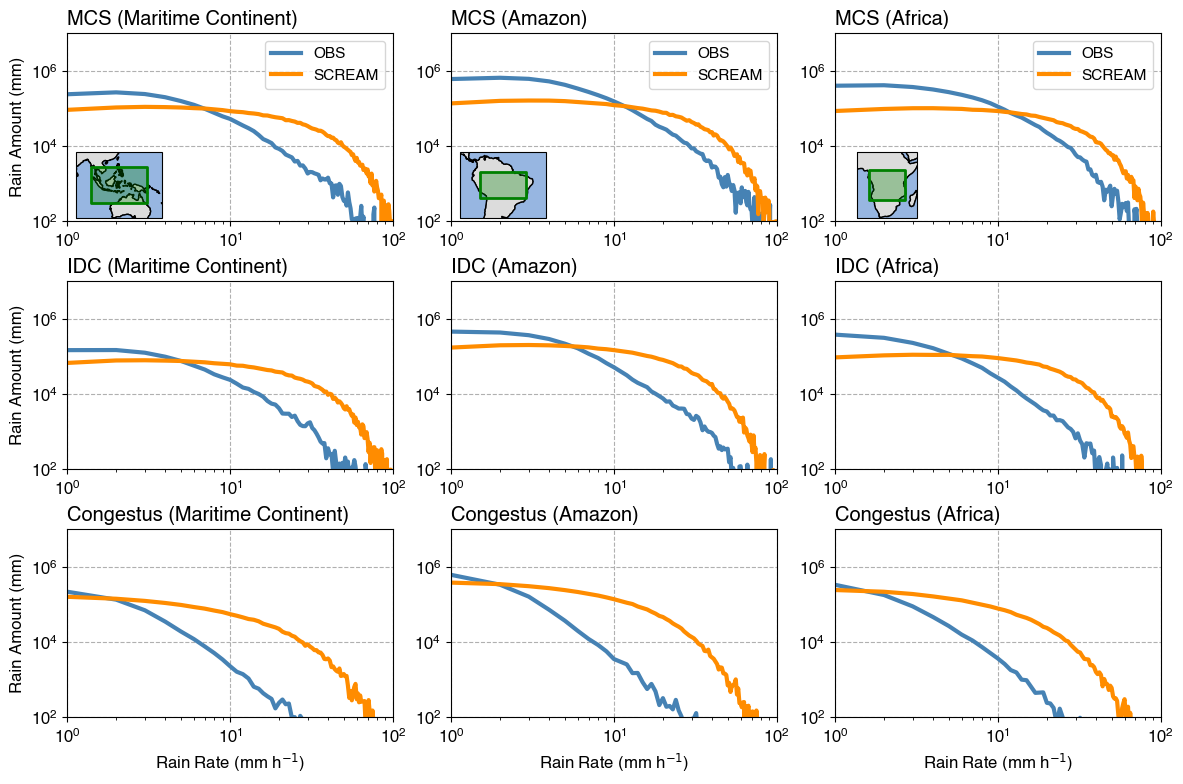

In [25]:
reg = ['maritime_continent','amazon','africa']
xbins = dsobs['bins']

mcsamt_hist_obs = [(dsobs.mcs_land.sel(region=reg[0])) * rrbins, (dsobs.mcs_land.sel(region=reg[1])) * rrbins, (dsobs.mcs_land.sel(region=reg[2])) * rrbins]
idcamt_hist_obs = [(dsobs.idc_land.sel(region=reg[0])) * rrbins, (dsobs.idc_land.sel(region=reg[1])) * rrbins, (dsobs.idc_land.sel(region=reg[2])) * rrbins]
congamt_hist_obs = [(dsobs.congestus_land.sel(region=reg[0])) * rrbins, (dsobs.congestus_land.sel(region=reg[1])) * rrbins, (dsobs.congestus_land.sel(region=reg[2])) * rrbins]

mcsamt_hist_m1 = [(dsm1.mcs_land.sel(region=reg[0])) * rrbins, (dsm1.mcs_land.sel(region=reg[1])) * rrbins, (dsm1.mcs_land.sel(region=reg[2])) * rrbins]
idcamt_hist_m1 = [(dsm1.idc_land.sel(region=reg[0])) * rrbins, (dsm1.idc_land.sel(region=reg[1])) * rrbins, (dsm1.idc_land.sel(region=reg[2])) * rrbins]
congamt_hist_m1 = [(dsm1.congestus_land.sel(region=reg[0])) * rrbins, (dsm1.congestus_land.sel(region=reg[1])) * rrbins, (dsm1.congestus_land.sel(region=reg[2])) * rrbins]

data_obs = [mcsamt_hist_obs, idcamt_hist_obs, congamt_hist_obs]
data_m1 = [mcsamt_hist_m1, idcamt_hist_m1, congamt_hist_m1]

titles = [['MCS (Maritime Continent)', 'MCS (Amazon)', 'MCS (Africa)'],
          ['IDC (Maritime Continent)', 'IDC (Amazon)', 'IDC (Africa)'],
          ['Congestus (Maritime Continent)', 'Congestus (Amazon)', 'Congestus (Africa)']]
xlabels = ['','','Rain Rate (mm h$^{-1}$)']
ylabels = ['Rain Amount (mm)', '', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs':'OBS', 'm1':'SCREAM'}

bounds = [[lon_box[reg[0]][0], lon_box[reg[0]][1], lat_box[reg[0]][0], lat_box[reg[0]][1]],
          [lon_box[reg[1]][0], lon_box[reg[1]][1], lat_box[reg[1]][0], lat_box[reg[1]][1]],
          [lon_box[reg[2]][0], lon_box[reg[2]][1], lat_box[reg[2]][0], lat_box[reg[2]][1]],]
map_extent = [[bounds[0][0]-15,bounds[0][1]+15,bounds[0][2]-15,bounds[0][3]+15],
              [bounds[1][0]-15,bounds[1][1]+15,bounds[1][2]-15,bounds[1][3]+15],
              [bounds[2][0]-10,bounds[2][1]+10,bounds[2][2]-15,bounds[2][3]+15],]
inset_param = {'width':'30%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainamount_hist_mcs_idc_congestus_3land.png'
        
fig = plot_pdf_mxn(3, 3, xbins, data_obs, data_m1,   
                       titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                       map_extent, bounds, inset_param, figname)

In [26]:
def plot_pdf_mxn(nrow, ncol, bins, data_obs1, data_obs2, data_m1, data_m2,
                 titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                 map_extent, bounds, inset_param, figname, legend_loc='best', legend_fontsize=10, figsize=[12,8]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for row in range(0,nrow):
        for col in range(0,ncol): 
            ax = axes[row][col]
            ax.plot(bins, data_obs1[row][col], colors['obs'], lw=3, label=legends['obs1'])
            ax.plot(bins, data_m1[row][col], colors['m1'], lw=3, label=legends['m1'])
            ax.plot(bins, data_obs2[row][col], colors['obs'], lw=3, ls='--', label=legends['obs2'])
            ax.plot(bins, data_m2[row][col], colors['m1'], lw=3, ls='--', label=legends['m2'])

            if (row==0) & (col==0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[col])
#             ax.set_xticks(xticks)
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            ax.set_xscale(xscales)
            ax.set_yscale(yscales)

            # Plot inset map
            resolution = '110m'
            land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
            ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
            proj = ccrs.PlateCarree(central_longitude=180)
            box_proj = ccrs.PlateCarree(central_longitude=0)
            sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                axes_kwargs=dict(map_projection=proj))
            sub_ax.set_extent(map_extent[row][col], crs=box_proj)
            # Add land, coastlines, borders to inset
            sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
            sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
            sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
            # Plot a box region in the inset
            box = sgeom.box(minx=bounds[row][col][0], maxx=bounds[row][col][1], miny=bounds[row][col][2], maxy=bounds[row][col][3])
            sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
            sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-26-c5919f668803>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


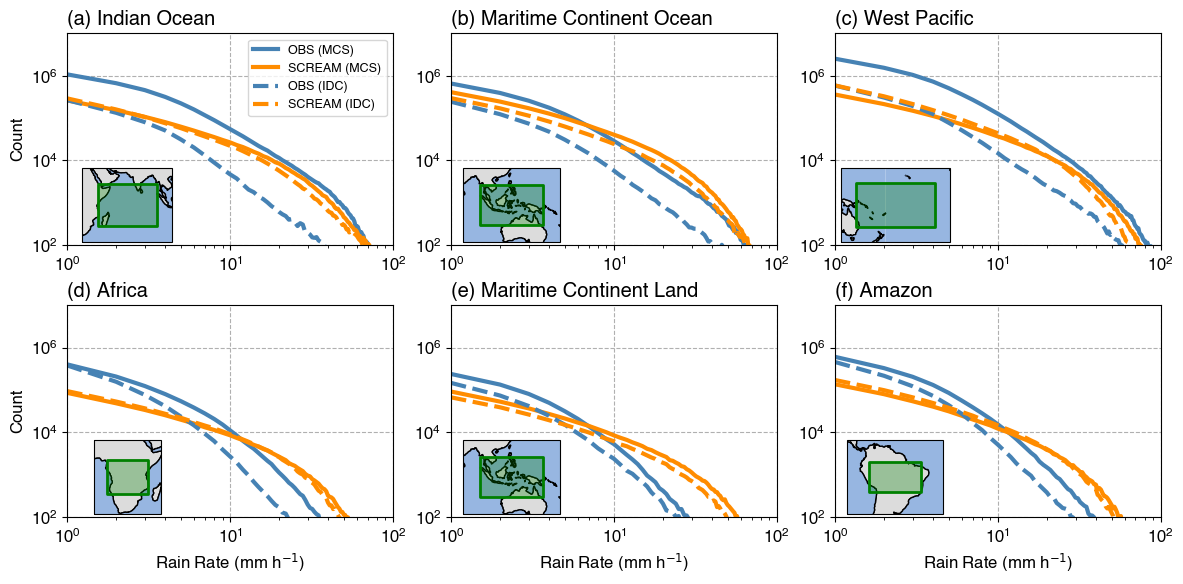

In [27]:
reg_ocean = ['indian_ocean','maritime_continent', 'wpacific']
reg_land = ['africa','maritime_continent','amazon']
xbins = dsobs['bins']
data_obs1 = [[dsobs.mcs_ocean.sel(region=reg_ocean[0]), dsobs.mcs_ocean.sel(region=reg_ocean[1]), dsobs.mcs_ocean.sel(region=reg_ocean[2])],
             [dsobs.mcs_land.sel(region=reg_land[0]), dsobs.mcs_land.sel(region=reg_land[1]), dsobs.mcs_land.sel(region=reg_land[2])]]
data_obs2 = [[dsobs.idc_ocean.sel(region=reg_ocean[0]), dsobs.idc_ocean.sel(region=reg_ocean[1]), dsobs.idc_ocean.sel(region=reg_ocean[2])],
             [dsobs.idc_land.sel(region=reg_land[0]), dsobs.idc_land.sel(region=reg_land[1]), dsobs.idc_land.sel(region=reg_land[2])]]
data_m1 = [[dsm1.mcs_ocean.sel(region=reg_ocean[0]), dsm1.mcs_ocean.sel(region=reg_ocean[1]), dsm1.mcs_ocean.sel(region=reg_ocean[2])],
           [dsm1.mcs_land.sel(region=reg_land[0]), dsm1.mcs_land.sel(region=reg_land[1]), dsm1.mcs_land.sel(region=reg_land[2])]]
data_m2 = [[dsm1.idc_ocean.sel(region=reg_ocean[0]), dsm1.idc_ocean.sel(region=reg_ocean[1]), dsm1.idc_ocean.sel(region=reg_ocean[2])],
           [dsm1.idc_land.sel(region=reg_land[0]), dsm1.idc_land.sel(region=reg_land[1]), dsm1.idc_land.sel(region=reg_land[2])]]
titles = [['(a) Indian Ocean', '(b) Maritime Continent Ocean', '(c) West Pacific'],
          ['(d) Africa', '(e) Maritime Continent Land', '(f) Amazon']]
xlabels = ['','Rain Rate (mm h$^{-1}$)']
ylabels = ['Count', '', '']
xlims = [1, 100]
ylims = [[[1e2,1e7],[1e2,1e7],[1e2,1e7]],
         [[1e2,1e7],[1e2,1e7],[1e2,1e7]]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[[lon_box[reg_ocean[0]][0], lon_box[reg_ocean[0]][1], lat_box[reg_ocean[0]][0], lat_box[reg_ocean[0]][1]],
           [lon_box[reg_ocean[1]][0], lon_box[reg_ocean[1]][1], lat_box[reg_ocean[1]][0], lat_box[reg_ocean[1]][1]],
           [lon_box[reg_ocean[2]][0], lon_box[reg_ocean[2]][1], lat_box[reg_ocean[2]][0], lat_box[reg_ocean[2]][1]]],
          [[lon_box[reg_land[0]][0], lon_box[reg_land[0]][1], lat_box[reg_land[0]][0], lat_box[reg_land[0]][1]],
           [lon_box[reg_land[1]][0], lon_box[reg_land[1]][1], lat_box[reg_land[1]][0], lat_box[reg_land[1]][1]],
           [lon_box[reg_land[2]][0], lon_box[reg_land[2]][1], lat_box[reg_land[2]][0], lat_box[reg_land[2]][1]]]]
map_extent = [[[bounds[0][0][0]-15,bounds[0][0][1]+15,bounds[0][0][2]-15,bounds[0][0][3]+15],
              [bounds[0][1][0]-15,bounds[0][1][1]+15,bounds[0][1][2]-15,bounds[0][1][3]+15],
              [bounds[0][2][0]-15,bounds[0][2][1]+15,bounds[0][2][2]-15,bounds[0][2][3]+15]],
             [[bounds[1][0][0]-10,bounds[1][0][1]+10,bounds[1][0][2]-15,bounds[1][0][3]+15],
              [bounds[1][1][0]-15,bounds[1][1][1]+15,bounds[1][1][2]-15,bounds[1][1][3]+15],
              [bounds[1][2][0]-15,bounds[1][2][1]+15,bounds[1][2][2]-15,bounds[1][2][3]+15]]]
inset_param = {'width':'35%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_hist_mcs_idc_3ocean_3land.png'
        
fig = plot_pdf_mxn(2, 3, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='upper right', legend_fontsize=9, figsize=[12,6])

<ipython-input-26-c5919f668803>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


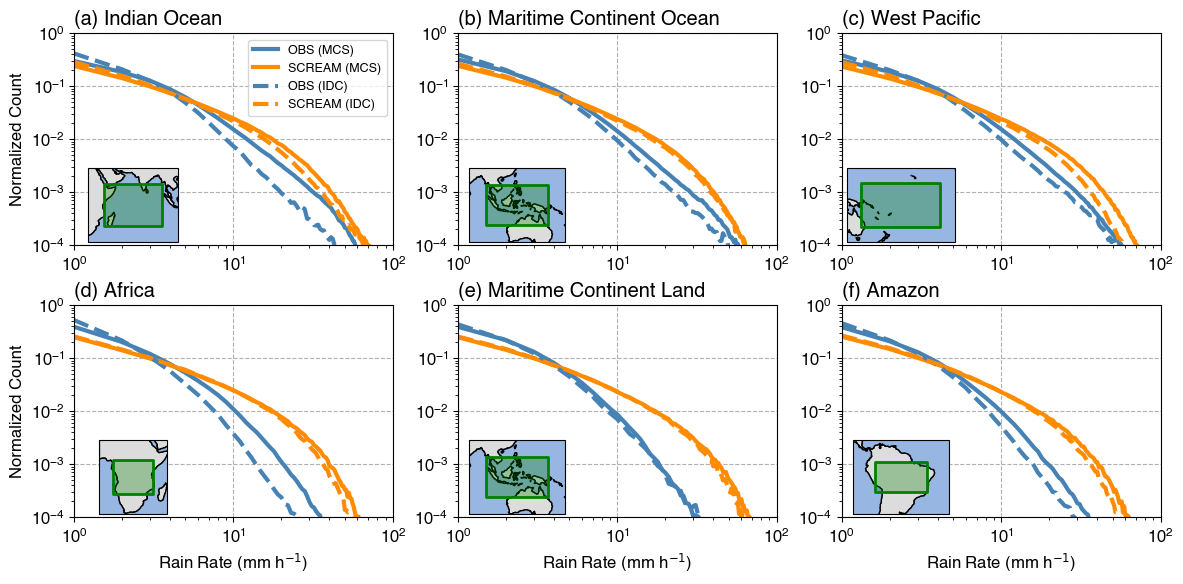

In [28]:
reg_ocean = ['indian_ocean','maritime_continent', 'wpacific']
reg_land = ['africa','maritime_continent','amazon']
xbins = dsobs['bins']
data_obs1 = [[dsobs.mcs_ocean.sel(region=reg_ocean[0]) / np.nansum(dsobs.mcs_ocean.sel(region=reg_ocean[0])), 
              dsobs.mcs_ocean.sel(region=reg_ocean[1]) / np.nansum(dsobs.mcs_ocean.sel(region=reg_ocean[1])), 
              dsobs.mcs_ocean.sel(region=reg_ocean[2]) / np.nansum(dsobs.mcs_ocean.sel(region=reg_ocean[2]))],
             [dsobs.mcs_land.sel(region=reg_land[0]) / np.nansum(dsobs.mcs_land.sel(region=reg_land[0])), 
              dsobs.mcs_land.sel(region=reg_land[1]) / np.nansum(dsobs.mcs_land.sel(region=reg_land[1])), 
              dsobs.mcs_land.sel(region=reg_land[2]) / np.nansum(dsobs.mcs_land.sel(region=reg_land[2]))]]
data_obs2 = [[dsobs.idc_ocean.sel(region=reg_ocean[0]) / np.nansum(dsobs.idc_ocean.sel(region=reg_ocean[0])), 
              dsobs.idc_ocean.sel(region=reg_ocean[1]) / np.nansum(dsobs.idc_ocean.sel(region=reg_ocean[1])), 
              dsobs.idc_ocean.sel(region=reg_ocean[2]) / np.nansum(dsobs.idc_ocean.sel(region=reg_ocean[2]))],
             [dsobs.idc_land.sel(region=reg_land[0]) / np.nansum(dsobs.idc_land.sel(region=reg_land[0])), 
              dsobs.idc_land.sel(region=reg_land[1]) / np.nansum(dsobs.idc_land.sel(region=reg_land[1])), 
              dsobs.idc_land.sel(region=reg_land[2]) / np.nansum(dsobs.idc_land.sel(region=reg_land[2]))]]
data_m1 = [[dsm1.mcs_ocean.sel(region=reg_ocean[0]) / np.nansum(dsm1.mcs_ocean.sel(region=reg_ocean[0])), 
            dsm1.mcs_ocean.sel(region=reg_ocean[1]) / np.nansum(dsm1.mcs_ocean.sel(region=reg_ocean[1])), 
            dsm1.mcs_ocean.sel(region=reg_ocean[2]) / np.nansum(dsm1.mcs_ocean.sel(region=reg_ocean[2]))],
           [dsm1.mcs_land.sel(region=reg_land[0]) / np.nansum(dsm1.mcs_land.sel(region=reg_land[0])), 
            dsm1.mcs_land.sel(region=reg_land[1]) / np.nansum(dsm1.mcs_land.sel(region=reg_land[1])), 
            dsm1.mcs_land.sel(region=reg_land[2]) / np.nansum(dsm1.mcs_land.sel(region=reg_land[2]))]]
data_m2 = [[dsm1.idc_ocean.sel(region=reg_ocean[0]) / np.nansum(dsm1.idc_ocean.sel(region=reg_ocean[0])), 
            dsm1.idc_ocean.sel(region=reg_ocean[1]) / np.nansum(dsm1.idc_ocean.sel(region=reg_ocean[1])), 
            dsm1.idc_ocean.sel(region=reg_ocean[2]) / np.nansum(dsm1.idc_ocean.sel(region=reg_ocean[2]))],
           [dsm1.idc_land.sel(region=reg_land[0]) / np.nansum(dsm1.idc_land.sel(region=reg_land[0])), 
            dsm1.idc_land.sel(region=reg_land[1]) / np.nansum(dsm1.idc_land.sel(region=reg_land[1])), 
            dsm1.idc_land.sel(region=reg_land[2]) / np.nansum(dsm1.idc_land.sel(region=reg_land[2]))]]
titles = [['(a) Indian Ocean', '(b) Maritime Continent Ocean', '(c) West Pacific'],
          ['(d) Africa', '(e) Maritime Continent Land', '(f) Amazon']]
xlabels = ['','Rain Rate (mm h$^{-1}$)']
ylabels = ['Normalized Count', '', '']
xlims = [1, 100]
ylims = [[[1e-4,1],[1e-4,1],[1e-4,1]],
         [[1e-4,1],[1e-4,1],[1e-4,1]]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[[lon_box[reg_ocean[0]][0], lon_box[reg_ocean[0]][1], lat_box[reg_ocean[0]][0], lat_box[reg_ocean[0]][1]],
           [lon_box[reg_ocean[1]][0], lon_box[reg_ocean[1]][1], lat_box[reg_ocean[1]][0], lat_box[reg_ocean[1]][1]],
           [lon_box[reg_ocean[2]][0], lon_box[reg_ocean[2]][1], lat_box[reg_ocean[2]][0], lat_box[reg_ocean[2]][1]]],
          [[lon_box[reg_land[0]][0], lon_box[reg_land[0]][1], lat_box[reg_land[0]][0], lat_box[reg_land[0]][1]],
           [lon_box[reg_land[1]][0], lon_box[reg_land[1]][1], lat_box[reg_land[1]][0], lat_box[reg_land[1]][1]],
           [lon_box[reg_land[2]][0], lon_box[reg_land[2]][1], lat_box[reg_land[2]][0], lat_box[reg_land[2]][1]]]]
map_extent = [[[bounds[0][0][0]-15,bounds[0][0][1]+15,bounds[0][0][2]-15,bounds[0][0][3]+15],
              [bounds[0][1][0]-15,bounds[0][1][1]+15,bounds[0][1][2]-15,bounds[0][1][3]+15],
              [bounds[0][2][0]-15,bounds[0][2][1]+15,bounds[0][2][2]-15,bounds[0][2][3]+15]],
             [[bounds[1][0][0]-10,bounds[1][0][1]+10,bounds[1][0][2]-15,bounds[1][0][3]+15],
              [bounds[1][1][0]-15,bounds[1][1][1]+15,bounds[1][1][2]-15,bounds[1][1][3]+15],
              [bounds[1][2][0]-15,bounds[1][2][1]+15,bounds[1][2][2]-15,bounds[1][2][3]+15]]]
inset_param = {'width':'35%', 'height':'35%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_mcs_idc_3ocean_3land.png'
        
fig = plot_pdf_mxn(2, 3, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='upper right', legend_fontsize=9, figsize=[12,6])

<ipython-input-26-c5919f668803>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


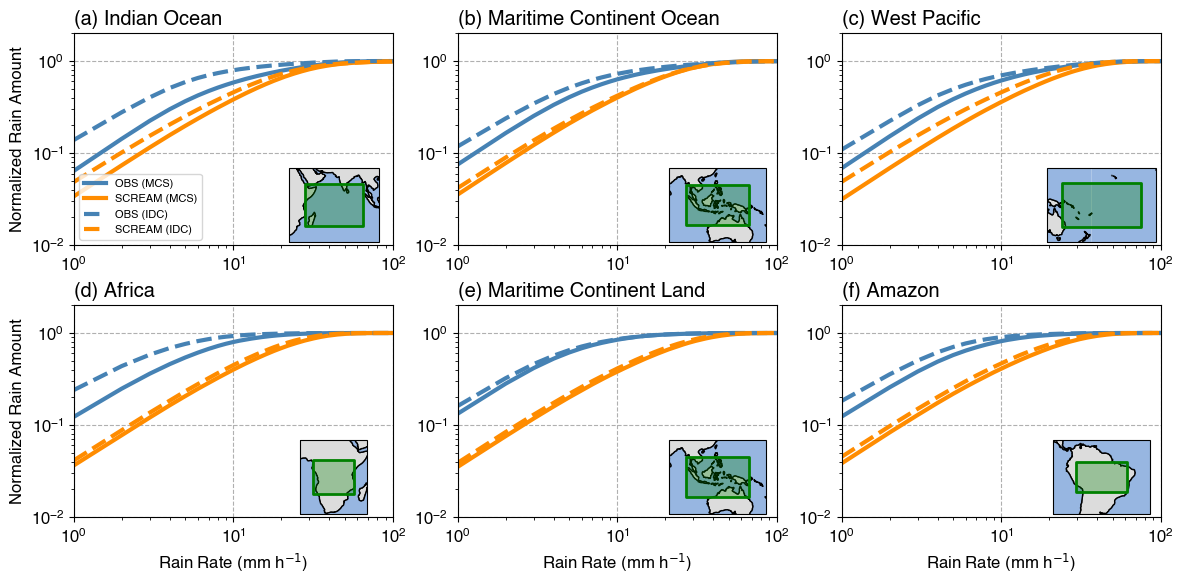

In [29]:
reg_ocean = ['indian_ocean','maritime_continent', 'wpacific']
reg_land = ['africa','maritime_continent','amazon']
xbins = dsobs['bins']

data_obs1 = [[norm_mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), norm_mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), norm_mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [norm_mcsamt_cumhist_land_obs.sel(region=reg_land[0]), norm_mcsamt_cumhist_land_obs.sel(region=reg_land[1]), norm_mcsamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_obs2 = [[norm_idcamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), norm_idcamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), norm_idcamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [norm_idcamt_cumhist_land_obs.sel(region=reg_land[0]), norm_idcamt_cumhist_land_obs.sel(region=reg_land[1]), norm_idcamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_m1 = [[norm_mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), norm_mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), norm_mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [norm_mcsamt_cumhist_land_m1.sel(region=reg_land[0]), norm_mcsamt_cumhist_land_m1.sel(region=reg_land[1]), norm_mcsamt_cumhist_land_m1.sel(region=reg_land[2])]]
data_m2 = [[norm_idcamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), norm_idcamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), norm_idcamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [norm_idcamt_cumhist_land_m1.sel(region=reg_land[0]), norm_idcamt_cumhist_land_m1.sel(region=reg_land[1]), norm_idcamt_cumhist_land_m1.sel(region=reg_land[2])]]

titles = [['(a) Indian Ocean', '(b) Maritime Continent Ocean', '(c) West Pacific'],
          ['(d) Africa', '(e) Maritime Continent Land', '(f) Amazon']]
xlabels = ['','Rain Rate (mm h$^{-1}$)']
ylabels = ['Normalized Rain Amount', '','']
xlims = [1, 100]
ylims = [[[1e-2,2],[1e-2,2],[1e-2,2]],
         [[1e-2,2],[1e-2,2],[1e-2,2]]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[[lon_box[reg_ocean[0]][0], lon_box[reg_ocean[0]][1], lat_box[reg_ocean[0]][0], lat_box[reg_ocean[0]][1]],
           [lon_box[reg_ocean[1]][0], lon_box[reg_ocean[1]][1], lat_box[reg_ocean[1]][0], lat_box[reg_ocean[1]][1]],
           [lon_box[reg_ocean[2]][0], lon_box[reg_ocean[2]][1], lat_box[reg_ocean[2]][0], lat_box[reg_ocean[2]][1]]],
          [[lon_box[reg_land[0]][0], lon_box[reg_land[0]][1], lat_box[reg_land[0]][0], lat_box[reg_land[0]][1]],
           [lon_box[reg_land[1]][0], lon_box[reg_land[1]][1], lat_box[reg_land[1]][0], lat_box[reg_land[1]][1]],
           [lon_box[reg_land[2]][0], lon_box[reg_land[2]][1], lat_box[reg_land[2]][0], lat_box[reg_land[2]][1]]]]
map_extent = [[[bounds[0][0][0]-15,bounds[0][0][1]+15,bounds[0][0][2]-15,bounds[0][0][3]+15],
              [bounds[0][1][0]-15,bounds[0][1][1]+15,bounds[0][1][2]-15,bounds[0][1][3]+15],
              [bounds[0][2][0]-15,bounds[0][2][1]+15,bounds[0][2][2]-15,bounds[0][2][3]+15]],
             [[bounds[1][0][0]-10,bounds[1][0][1]+10,bounds[1][0][2]-15,bounds[1][0][3]+15],
              [bounds[1][1][0]-15,bounds[1][1][1]+15,bounds[1][1][2]-15,bounds[1][1][3]+15],
              [bounds[1][2][0]-15,bounds[1][2][1]+15,bounds[1][2][2]-15,bounds[1][2][3]+15]]]
inset_param = {'width':'35%', 'height':'35%', 'loc':'lower right', 'borderpad':0.2}
figname = f'{figdir}rainamount_cdf_mcs_idc_3ocean_3land.png'
        
fig = plot_pdf_mxn(2, 3, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='lower left', legend_fontsize=8, figsize=[12,6])

<ipython-input-26-c5919f668803>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


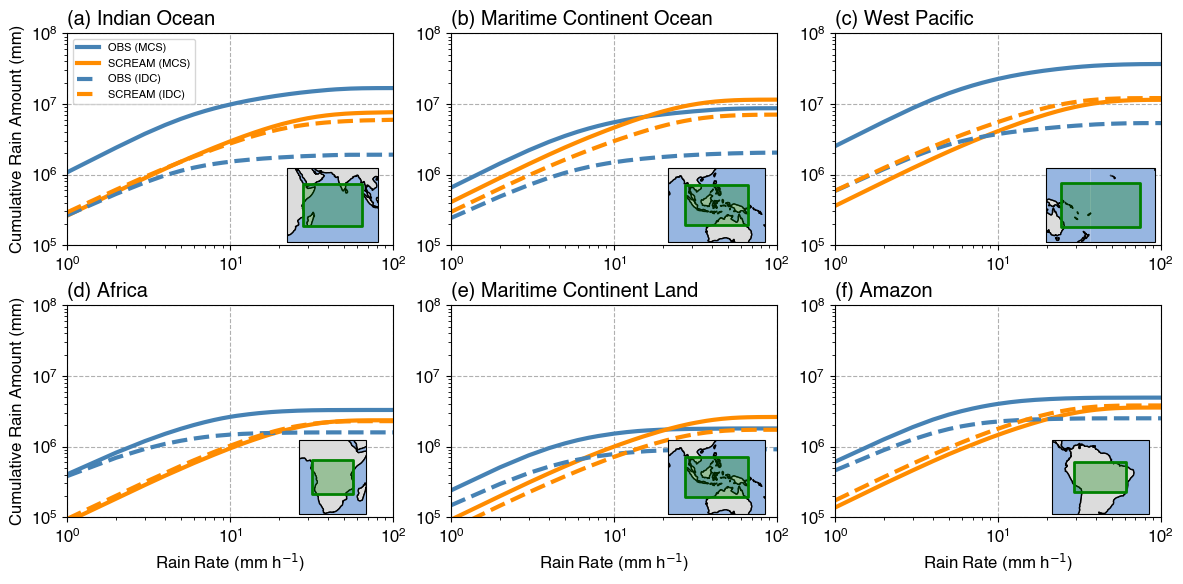

In [30]:
reg_ocean = ['indian_ocean','maritime_continent', 'wpacific']
reg_land = ['africa','maritime_continent','amazon']
xbins = dsobs['bins']

data_obs1 = [[mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [mcsamt_cumhist_land_obs.sel(region=reg_land[0]), mcsamt_cumhist_land_obs.sel(region=reg_land[1]), mcsamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_obs2 = [[idcamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), idcamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), idcamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [idcamt_cumhist_land_obs.sel(region=reg_land[0]), idcamt_cumhist_land_obs.sel(region=reg_land[1]), idcamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_m1 = [[mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [mcsamt_cumhist_land_m1.sel(region=reg_land[0]), mcsamt_cumhist_land_m1.sel(region=reg_land[1]), mcsamt_cumhist_land_m1.sel(region=reg_land[2])]]
data_m2 = [[idcamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), idcamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), idcamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [idcamt_cumhist_land_m1.sel(region=reg_land[0]), idcamt_cumhist_land_m1.sel(region=reg_land[1]), idcamt_cumhist_land_m1.sel(region=reg_land[2])]]

titles = [['(a) Indian Ocean', '(b) Maritime Continent Ocean', '(c) West Pacific'],
          ['(d) Africa', '(e) Maritime Continent Land', '(f) Amazon']]
xlabels = ['','Rain Rate (mm h$^{-1}$)']
ylabels = ['Cumulative Rain Amount (mm)', '','']
xlims = [1, 100]
ylims = [[[1e5,1e8],[1e5,1e8],[1e5,1e8]],
         [[1e5,1e8],[1e5,1e8],[1e5,1e8]]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[[lon_box[reg_ocean[0]][0], lon_box[reg_ocean[0]][1], lat_box[reg_ocean[0]][0], lat_box[reg_ocean[0]][1]],
           [lon_box[reg_ocean[1]][0], lon_box[reg_ocean[1]][1], lat_box[reg_ocean[1]][0], lat_box[reg_ocean[1]][1]],
           [lon_box[reg_ocean[2]][0], lon_box[reg_ocean[2]][1], lat_box[reg_ocean[2]][0], lat_box[reg_ocean[2]][1]]],
          [[lon_box[reg_land[0]][0], lon_box[reg_land[0]][1], lat_box[reg_land[0]][0], lat_box[reg_land[0]][1]],
           [lon_box[reg_land[1]][0], lon_box[reg_land[1]][1], lat_box[reg_land[1]][0], lat_box[reg_land[1]][1]],
           [lon_box[reg_land[2]][0], lon_box[reg_land[2]][1], lat_box[reg_land[2]][0], lat_box[reg_land[2]][1]]]]
map_extent = [[[bounds[0][0][0]-15,bounds[0][0][1]+15,bounds[0][0][2]-15,bounds[0][0][3]+15],
              [bounds[0][1][0]-15,bounds[0][1][1]+15,bounds[0][1][2]-15,bounds[0][1][3]+15],
              [bounds[0][2][0]-15,bounds[0][2][1]+15,bounds[0][2][2]-15,bounds[0][2][3]+15]],
             [[bounds[1][0][0]-10,bounds[1][0][1]+10,bounds[1][0][2]-15,bounds[1][0][3]+15],
              [bounds[1][1][0]-15,bounds[1][1][1]+15,bounds[1][1][2]-15,bounds[1][1][3]+15],
              [bounds[1][2][0]-15,bounds[1][2][1]+15,bounds[1][2][2]-15,bounds[1][2][3]+15]]]
inset_param = {'width':'35%', 'height':'35%', 'loc':'lower right', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_mcs_idc_3ocean_3land.png'
        
fig = plot_pdf_mxn(2, 3, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='upper left', legend_fontsize=8, figsize=[12,6])

<ipython-input-26-c5919f668803>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


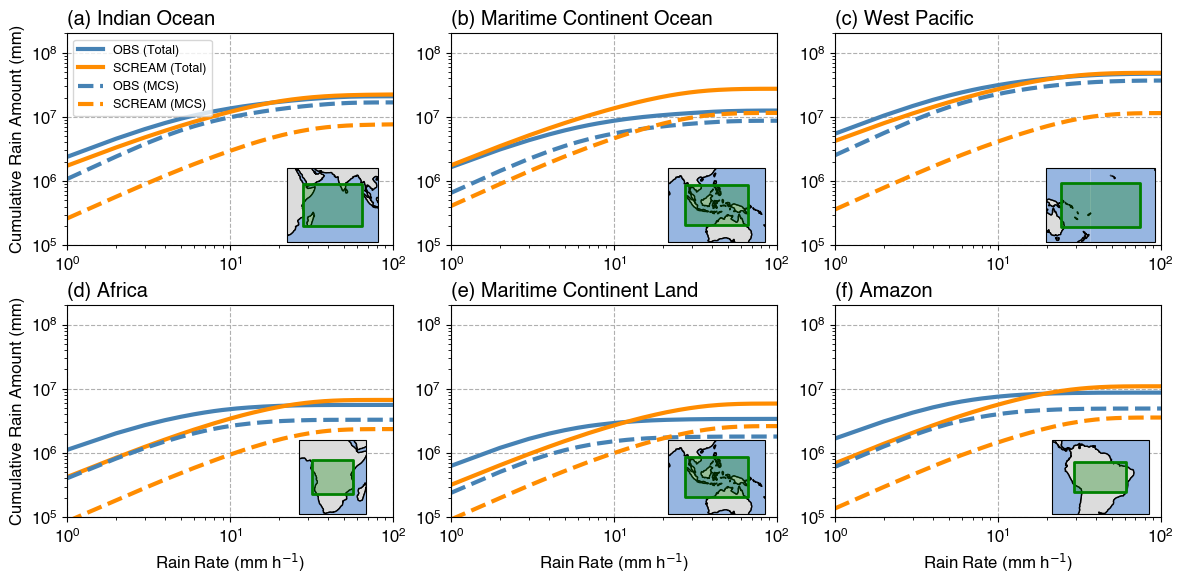

In [31]:
reg_ocean = ['indian_ocean','maritime_continent', 'wpacific']
reg_land = ['africa','maritime_continent','amazon']
xbins = dsobs['bins']

data_obs1 = [[totamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), totamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), totamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [totamt_cumhist_land_obs.sel(region=reg_land[0]), totamt_cumhist_land_obs.sel(region=reg_land[1]), totamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_obs2 = [[mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[0]), mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[1]), mcsamt_cumhist_ocean_obs.sel(region=reg_ocean[2])],
             [mcsamt_cumhist_land_obs.sel(region=reg_land[0]), mcsamt_cumhist_land_obs.sel(region=reg_land[1]), mcsamt_cumhist_land_obs.sel(region=reg_land[2])]]
data_m1 = [[totamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), totamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), totamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [totamt_cumhist_land_m1.sel(region=reg_land[0]), totamt_cumhist_land_m1.sel(region=reg_land[1]), totamt_cumhist_land_m1.sel(region=reg_land[2])]]
data_m2 = [[mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[0]), mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[1]), mcsamt_cumhist_ocean_m1.sel(region=reg_ocean[2])],
           [mcsamt_cumhist_land_m1.sel(region=reg_land[0]), mcsamt_cumhist_land_m1.sel(region=reg_land[1]), mcsamt_cumhist_land_m1.sel(region=reg_land[2])]]

titles = [['(a) Indian Ocean', '(b) Maritime Continent Ocean', '(c) West Pacific'],
          ['(d) Africa', '(e) Maritime Continent Land', '(f) Amazon']]
xlabels = ['','Rain Rate (mm h$^{-1}$)']
ylabels = ['Cumulative Rain Amount (mm)', '','']
xlims = [1, 100]
ylims = [[[1e5,2e8],[1e5,2e8],[1e5,2e8]],
         [[1e5,2e8],[1e5,2e8],[1e5,2e8]]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (Total)', 'm1':'SCREAM (Total)', 'obs2':'OBS (MCS)', 'm2':'SCREAM (MCS)'}

bounds = [[[lon_box[reg_ocean[0]][0], lon_box[reg_ocean[0]][1], lat_box[reg_ocean[0]][0], lat_box[reg_ocean[0]][1]],
           [lon_box[reg_ocean[1]][0], lon_box[reg_ocean[1]][1], lat_box[reg_ocean[1]][0], lat_box[reg_ocean[1]][1]],
           [lon_box[reg_ocean[2]][0], lon_box[reg_ocean[2]][1], lat_box[reg_ocean[2]][0], lat_box[reg_ocean[2]][1]]],
          [[lon_box[reg_land[0]][0], lon_box[reg_land[0]][1], lat_box[reg_land[0]][0], lat_box[reg_land[0]][1]],
           [lon_box[reg_land[1]][0], lon_box[reg_land[1]][1], lat_box[reg_land[1]][0], lat_box[reg_land[1]][1]],
           [lon_box[reg_land[2]][0], lon_box[reg_land[2]][1], lat_box[reg_land[2]][0], lat_box[reg_land[2]][1]]]]
map_extent = [[[bounds[0][0][0]-15,bounds[0][0][1]+15,bounds[0][0][2]-15,bounds[0][0][3]+15],
              [bounds[0][1][0]-15,bounds[0][1][1]+15,bounds[0][1][2]-15,bounds[0][1][3]+15],
              [bounds[0][2][0]-15,bounds[0][2][1]+15,bounds[0][2][2]-15,bounds[0][2][3]+15]],
             [[bounds[1][0][0]-10,bounds[1][0][1]+10,bounds[1][0][2]-15,bounds[1][0][3]+15],
              [bounds[1][1][0]-15,bounds[1][1][1]+15,bounds[1][1][2]-15,bounds[1][1][3]+15],
              [bounds[1][2][0]-15,bounds[1][2][1]+15,bounds[1][2][2]-15,bounds[1][2][3]+15]]]
inset_param = {'width':'35%', 'height':'35%', 'loc':'lower right', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_total_mcs_3ocean_3land.png'
        
fig = plot_pdf_mxn(2, 3, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='upper left', legend_fontsize=9, figsize=[12,6])

In [32]:
def plot_pdf_1row(ncol, bins, data_obs1, data_obs2, data_m1, data_m2,
                 titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                 map_extent, bounds, inset_param, figname, legend_loc='best', legend_fontsize=10, figsize=[12,8]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=1, ncols=ncol, figsize=figsize, dpi=100)

    colors = {'obs':'steelblue', 'm1':'darkorange'}

    for col in range(0,ncol): 
        ax = axes[col]
        ax.plot(bins, data_obs1[col], colors['obs'], lw=3, label=legends['obs1'])
        ax.plot(bins, data_m1[col], colors['m1'], lw=3, label=legends['m1'])
        ax.plot(bins, data_obs2[col], colors['obs'], lw=3, ls='--', label=legends['obs2'])
        ax.plot(bins, data_m2[col], colors['m1'], lw=3, ls='--', label=legends['m2'])

        if (col==1): 
            ax.legend(fontsize=legend_fontsize, loc=legend_loc)
        ax.grid(which='major', ls='--')
        ax.set_title(titles[col], loc='left')
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels[col])
#             ax.set_xticks(xticks)
        ax.set_xlim(xlims[0], xlims[1])
        ax.set_ylim(ylims[col][0], ylims[col][1])
        ax.set_xscale(xscales)
        ax.set_yscale(yscales)

        # Plot inset map
        if (col==0): 
            resolution = '110m'
            land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
            ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
            proj = ccrs.PlateCarree(central_longitude=180)
            box_proj = ccrs.PlateCarree(central_longitude=0)
            sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                axes_kwargs=dict(map_projection=proj))
            sub_ax.set_extent(map_extent[col], crs=box_proj)
            # Add land, coastlines, borders to inset
            sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
            sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
            sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
            # Plot a box region in the inset
            box = sgeom.box(minx=bounds[col][0], maxx=bounds[col][1], miny=bounds[col][2], maxy=bounds[col][3])
            sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
            sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-32-beeb781308ef>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


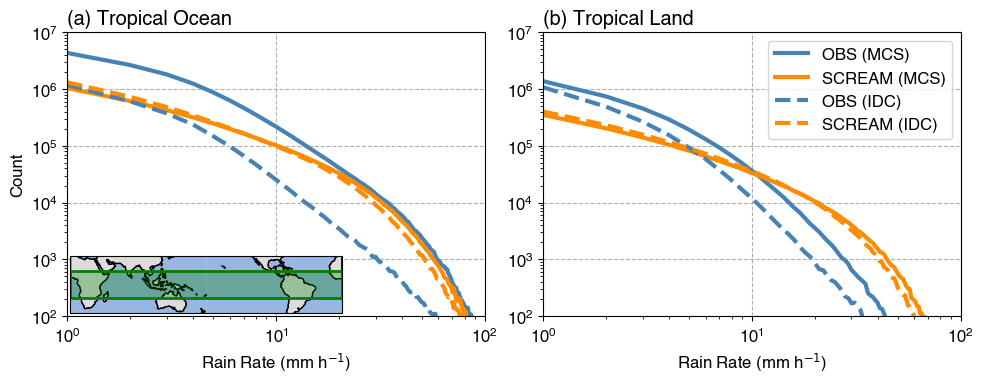

In [33]:
reg = 'tropics'
xbins = dsobs['bins']
data_obs1 = [dsobs.mcs_ocean.sel(region=reg), dsobs.mcs_land.sel(region=reg)]
data_obs2 = [dsobs.idc_ocean.sel(region=reg), dsobs.idc_land.sel(region=reg)]
data_m1 = [dsm1.mcs_ocean.sel(region=reg), dsm1.mcs_land.sel(region=reg)]
data_m2 = [dsm1.idc_ocean.sel(region=reg), dsm1.idc_land.sel(region=reg)]
titles = ['(a) Tropical Ocean', '(b) Tropical Land']
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = ['Count', '']
xlims = [1, 100]
ylims = [[1e2,1e7],[1e2,1e7]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]],
          [lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]]]
map_extent = [[bounds[0][0],bounds[0][1],bounds[0][2]-20,bounds[0][3]+20],
              [bounds[1][0],bounds[1][1],bounds[1][2]-20,bounds[1][3]+20]]
inset_param = {'width':'65%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_hist_mcs_idc_tropics.png'
        
fig = plot_pdf_1row(2, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='upper right', legend_fontsize=12, figsize=[10,4])

<ipython-input-32-beeb781308ef>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


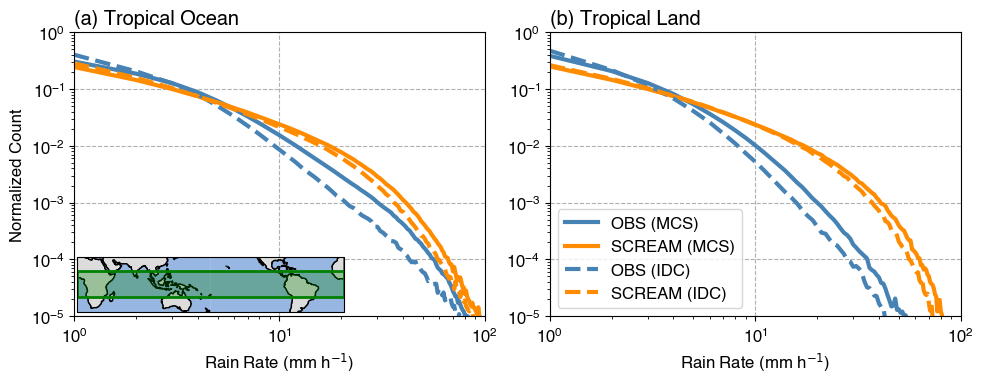

In [34]:
reg = 'tropics'
xbins = dsobs['bins']
data_obs1 = [(dsobs.mcs_ocean.sel(region=reg) / np.nansum(dsobs.mcs_ocean.sel(region=reg))), 
             (dsobs.mcs_land.sel(region=reg) / np.nansum(dsobs.mcs_land.sel(region=reg)))]
data_obs2 = [(dsobs.idc_ocean.sel(region=reg) / np.nansum(dsobs.idc_ocean.sel(region=reg))), 
             (dsobs.idc_land.sel(region=reg) / np.nansum(dsobs.idc_land.sel(region=reg)))]
data_m1 = [(dsm1.mcs_ocean.sel(region=reg) / np.nansum(dsm1.mcs_ocean.sel(region=reg))), 
             (dsm1.mcs_land.sel(region=reg) / np.nansum(dsm1.mcs_land.sel(region=reg)))]
data_m2 = [(dsm1.idc_ocean.sel(region=reg) / np.nansum(dsm1.idc_ocean.sel(region=reg))), 
             (dsm1.idc_land.sel(region=reg) / np.nansum(dsm1.idc_land.sel(region=reg)))]

titles = ['(a) Tropical Ocean', '(b) Tropical Land']
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = ['Normalized Count', '']
xlims = [1, 100]
ylims = [[1e-5,1],[1e-5,1]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]],
          [lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]]]
map_extent = [[bounds[0][0],bounds[0][1],bounds[0][2]-20,bounds[0][3]+20],
              [bounds[1][0],bounds[1][1],bounds[1][2]-20,bounds[1][3]+20]]
inset_param = {'width':'65%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_mcs_idc_tropics.png'
        
fig = plot_pdf_1row(2, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='lower left', legend_fontsize=12, figsize=[10,4])

<ipython-input-32-beeb781308ef>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


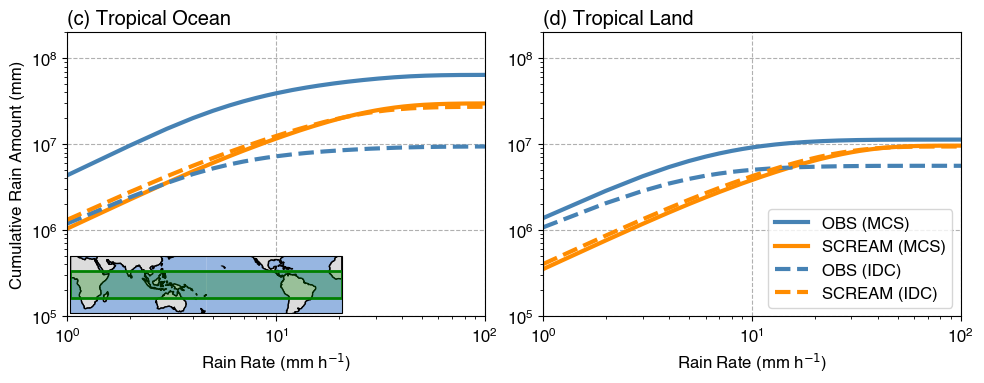

In [35]:
reg = 'tropics'
xbins = dsobs['bins']
data_obs1 = [mcsamt_cumhist_ocean_obs.sel(region=reg), mcsamt_cumhist_land_obs.sel(region=reg)]
data_obs2 = [idcamt_cumhist_ocean_obs.sel(region=reg), idcamt_cumhist_land_obs.sel(region=reg)]
data_m1 = [mcsamt_cumhist_ocean_m1.sel(region=reg), mcsamt_cumhist_land_m1.sel(region=reg)]
data_m2 = [idcamt_cumhist_ocean_m1.sel(region=reg), idcamt_cumhist_land_m1.sel(region=reg)]

titles = ['(c) Tropical Ocean', '(d) Tropical Land']
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = ['Cumulative Rain Amount (mm)', '']
xlims = [1, 100]
ylims = [[1e5,2e8],[1e5,2e8]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (MCS)', 'm1':'SCREAM (MCS)', 'obs2':'OBS (IDC)', 'm2':'SCREAM (IDC)'}

bounds = [[lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]],
          [lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]]]
map_extent = [[bounds[0][0],bounds[0][1],bounds[0][2]-20,bounds[0][3]+20],
              [bounds[1][0],bounds[1][1],bounds[1][2]-20,bounds[1][3]+20]]
inset_param = {'width':'65%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_mcs_idc_tropics.png'
        
fig = plot_pdf_1row(2, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='lower right', legend_fontsize=12, figsize=[10,4])

In [ ]:
figdir

<ipython-input-32-beeb781308ef>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


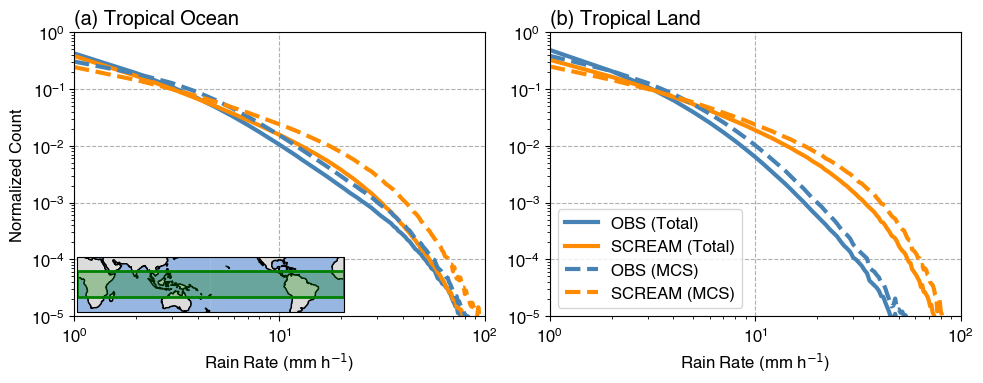

In [36]:
reg = 'tropics'
xbins = dsobs['bins']
data_obs1 = [(dsobs.total_ocean.sel(region=reg) / np.nansum(dsobs.total_ocean.sel(region=reg))), 
             (dsobs.total_land.sel(region=reg) / np.nansum(dsobs.total_land.sel(region=reg)))]
data_obs2 = [(dsobs.mcs_ocean.sel(region=reg) / np.nansum(dsobs.mcs_ocean.sel(region=reg))), 
             (dsobs.mcs_land.sel(region=reg) / np.nansum(dsobs.mcs_land.sel(region=reg)))]
data_m1 = [(dsm1.total_ocean.sel(region=reg) / np.nansum(dsm1.total_ocean.sel(region=reg))), 
             (dsm1.total_land.sel(region=reg) / np.nansum(dsm1.total_land.sel(region=reg)))]
data_m2 = [(dsm1.mcs_ocean.sel(region=reg) / np.nansum(dsm1.mcs_ocean.sel(region=reg))), 
             (dsm1.mcs_land.sel(region=reg) / np.nansum(dsm1.mcs_land.sel(region=reg)))]

titles = ['(a) Tropical Ocean', '(b) Tropical Land']
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = ['Normalized Count', '']
xlims = [1, 100]
ylims = [[1e-5,1],[1e-5,1]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (Total)', 'm1':'SCREAM (Total)', 'obs2':'OBS (MCS)', 'm2':'SCREAM (MCS)'}

bounds = [[lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]],
          [lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]]]
map_extent = [[bounds[0][0],bounds[0][1],bounds[0][2]-20,bounds[0][3]+20],
              [bounds[1][0],bounds[1][1],bounds[1][2]-20,bounds[1][3]+20]]
inset_param = {'width':'65%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainrate_pdf_total_mcs_tropics.png'
        
fig = plot_pdf_1row(2, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='lower left', legend_fontsize=12, figsize=[10,4])

<ipython-input-32-beeb781308ef>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5, h_pad=0.5)


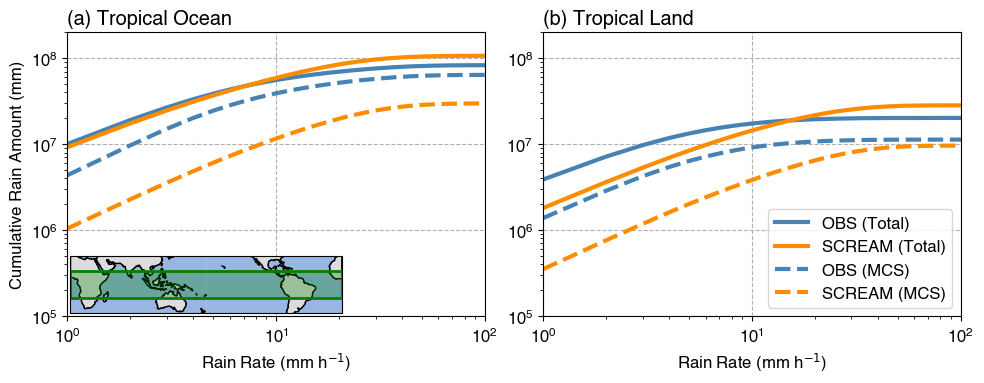

In [37]:
reg = 'tropics'
xbins = dsobs['bins']
data_obs1 = [(totamt_cumhist_ocean_obs.sel(region=reg)), (totamt_cumhist_land_obs.sel(region=reg))]
data_obs2 = [(mcsamt_cumhist_ocean_obs.sel(region=reg)), (mcsamt_cumhist_land_obs.sel(region=reg))]
data_m1 = [(totamt_cumhist_ocean_m1.sel(region=reg)), (totamt_cumhist_land_m1.sel(region=reg))]
data_m2 = [(mcsamt_cumhist_ocean_m1.sel(region=reg)), (mcsamt_cumhist_land_m1.sel(region=reg))]
titles = ['(a) Tropical Ocean', '(b) Tropical Land']
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = ['Cumulative Rain Amount (mm)', '']
xlims = [1, 100]
ylims = [[1e5,2e8],[1e5,2e8]]
xscales = 'log'
yscales = 'log'
legends = {'obs1':'OBS (Total)', 'm1':'SCREAM (Total)', 'obs2':'OBS (MCS)', 'm2':'SCREAM (MCS)'}

bounds = [[lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]],
          [lon_box[reg][0], lon_box[reg][1]-0.1, lat_box[reg][0], lat_box[reg][1]]]
map_extent = [[bounds[0][0],bounds[0][1],bounds[0][2]-20,bounds[0][3]+20],
              [bounds[1][0],bounds[1][1],bounds[1][2]-20,bounds[1][3]+20]]
inset_param = {'width':'65%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}
figname = f'{figdir}rainamount_cumhist_total_mcs_tropics.png'
        
fig = plot_pdf_1row(2, xbins, data_obs1, data_obs2, data_m1, data_m2, 
                   titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
                   map_extent, bounds, inset_param, figname, legend_loc='lower right', legend_fontsize=12, figsize=[10,4])

In [38]:
figdir

'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures/'

In [39]:
# region = 'maritime_continent'

# mcsamt_land_hist_obs = (dsobs.mcs_land.sel(region=region) / np.nansum(dsobs.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_obs = (dsobs.mcs_ocean.sel(region=region) / np.nansum(dsobs.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_obs = (dsobs.idc_land.sel(region=region) / np.nansum(dsobs.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_obs = (dsobs.idc_ocean.sel(region=region) / np.nansum(dsobs.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_obs = (dsobs.congestus_land.sel(region=region) / np.nansum(dsobs.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_obs = (dsobs.congestus_ocean.sel(region=region) / np.nansum(dsobs.congestus_ocean.sel(region=region))) * rrbins

# mcsamt_land_hist_m1 = (dsm1.mcs_land.sel(region=region) / np.nansum(dsm1.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_m1 = (dsm1.mcs_ocean.sel(region=region) / np.nansum(dsm1.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_m1 = (dsm1.idc_land.sel(region=region) / np.nansum(dsm1.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_m1 = (dsm1.idc_ocean.sel(region=region) / np.nansum(dsm1.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_m1 = (dsm1.congestus_land.sel(region=region) / np.nansum(dsm1.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_m1 = (dsm1.congestus_ocean.sel(region=region) / np.nansum(dsm1.congestus_ocean.sel(region=region))) * rrbins

# xbins = dsobs['bins']
# data_obs = [[mcsamt_land_hist_obs, mcsamt_ocean_hist_obs],
#             [idcamt_land_hist_obs, idcamt_ocean_hist_obs],
#             [congamt_land_hist_obs, congamt_ocean_hist_obs]]
# data_m1 = [[mcsamt_land_hist_m1, mcsamt_ocean_hist_m1],
#             [idcamt_land_hist_m1, idcamt_ocean_hist_m1],
#             [congamt_land_hist_m1, congamt_ocean_hist_m1]]
# titles = [['MCS Rain Amount (Land)', 'MCS Rain Amount (Ocean)'],
#           ['IDC Rain Amount (Land)', 'IDC Rain Amount (Ocean)'],
#           ['Congestus Rain Amount (Land)', 'Congestus Rain Amount (Ocean)']]
# xlabels = ['','','Rain Rate (mm h$^{-1}$)']
# ylabels = ['Normalized Rain Amount', '']
# xlims = [1, 100]
# ylims = [[1e-4,1],[1e-4,1],[1e-4,1]]
# xscales = 'log'
# yscales = 'log'
# legends = {'obs':'OBS', 'm1':'E3SM'}

# bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
# map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'lower center', 'borderpad':0.2}
# figname = f'{figdir}rainamount_pdf_mcs_idc_congestus_landocean_{region}.png'
        
# fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
#                        titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
#                        map_extent, bounds, inset_param, figname)

In [40]:
# region = 'wpacific'

# mcsamt_land_hist_obs = (dsobs.mcs_land.sel(region=region) / np.nansum(dsobs.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_obs = (dsobs.mcs_ocean.sel(region=region) / np.nansum(dsobs.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_obs = (dsobs.idc_land.sel(region=region) / np.nansum(dsobs.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_obs = (dsobs.idc_ocean.sel(region=region) / np.nansum(dsobs.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_obs = (dsobs.congestus_land.sel(region=region) / np.nansum(dsobs.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_obs = (dsobs.congestus_ocean.sel(region=region) / np.nansum(dsobs.congestus_ocean.sel(region=region))) * rrbins

# mcsamt_land_hist_m1 = (dsm1.mcs_land.sel(region=region) / np.nansum(dsm1.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_m1 = (dsm1.mcs_ocean.sel(region=region) / np.nansum(dsm1.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_m1 = (dsm1.idc_land.sel(region=region) / np.nansum(dsm1.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_m1 = (dsm1.idc_ocean.sel(region=region) / np.nansum(dsm1.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_m1 = (dsm1.congestus_land.sel(region=region) / np.nansum(dsm1.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_m1 = (dsm1.congestus_ocean.sel(region=region) / np.nansum(dsm1.congestus_ocean.sel(region=region))) * rrbins

# xbins = dsobs['bins']
# data_obs = [[mcsamt_land_hist_obs, mcsamt_ocean_hist_obs],
#             [idcamt_land_hist_obs, idcamt_ocean_hist_obs],
#             [congamt_land_hist_obs, congamt_ocean_hist_obs]]
# data_m1 = [[mcsamt_land_hist_m1, mcsamt_ocean_hist_m1],
#             [idcamt_land_hist_m1, idcamt_ocean_hist_m1],
#             [congamt_land_hist_m1, congamt_ocean_hist_m1]]
# titles = [['MCS Rain Amount (Land)', 'MCS Rain Amount (Ocean)'],
#           ['IDC Rain Amount (Land)', 'IDC Rain Amount (Ocean)'],
#           ['Congestus Rain Amount (Land)', 'Congestus Rain Amount (Ocean)']]
# xlabels = ['','','Rain Rate (mm h$^{-1}$)']
# ylabels = ['Normalized Rain Amount', '']
# xlims = [1, 100]
# ylims = [[1e-4,1],[1e-4,1],[1e-4,1]]
# xscales = 'log'
# yscales = 'log'
# legends = {'obs':'OBS', 'm1':'E3SM'}

# bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
# map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'lower center', 'borderpad':0.2}
# figname = f'{figdir}rainamount_pdf_mcs_idc_congestus_landocean_{region}.png'
        
# fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
#                        titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
#                        map_extent, bounds, inset_param, figname)

In [41]:
# region = 'indian_ocean'

# mcsamt_land_hist_obs = (dsobs.mcs_land.sel(region=region) / np.nansum(dsobs.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_obs = (dsobs.mcs_ocean.sel(region=region) / np.nansum(dsobs.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_obs = (dsobs.idc_land.sel(region=region) / np.nansum(dsobs.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_obs = (dsobs.idc_ocean.sel(region=region) / np.nansum(dsobs.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_obs = (dsobs.congestus_land.sel(region=region) / np.nansum(dsobs.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_obs = (dsobs.congestus_ocean.sel(region=region) / np.nansum(dsobs.congestus_ocean.sel(region=region))) * rrbins

# mcsamt_land_hist_m1 = (dsm1.mcs_land.sel(region=region) / np.nansum(dsm1.mcs_land.sel(region=region))) * rrbins
# mcsamt_ocean_hist_m1 = (dsm1.mcs_ocean.sel(region=region) / np.nansum(dsm1.mcs_ocean.sel(region=region))) * rrbins
# idcamt_land_hist_m1 = (dsm1.idc_land.sel(region=region) / np.nansum(dsm1.idc_land.sel(region=region))) * rrbins
# idcamt_ocean_hist_m1 = (dsm1.idc_ocean.sel(region=region) / np.nansum(dsm1.idc_ocean.sel(region=region))) * rrbins
# congamt_land_hist_m1 = (dsm1.congestus_land.sel(region=region) / np.nansum(dsm1.congestus_land.sel(region=region))) * rrbins
# congamt_ocean_hist_m1 = (dsm1.congestus_ocean.sel(region=region) / np.nansum(dsm1.congestus_ocean.sel(region=region))) * rrbins

# xbins = dsobs['bins']
# data_obs = [[mcsamt_land_hist_obs, mcsamt_ocean_hist_obs],
#             [idcamt_land_hist_obs, idcamt_ocean_hist_obs],
#             [congamt_land_hist_obs, congamt_ocean_hist_obs]]
# data_m1 = [[mcsamt_land_hist_m1, mcsamt_ocean_hist_m1],
#             [idcamt_land_hist_m1, idcamt_ocean_hist_m1],
#             [congamt_land_hist_m1, congamt_ocean_hist_m1]]
# titles = [['MCS Rain Amount (Land)', 'MCS Rain Amount (Ocean)'],
#           ['IDC Rain Amount (Land)', 'IDC Rain Amount (Ocean)'],
#           ['Congestus Rain Amount (Land)', 'Congestus Rain Amount (Ocean)']]
# xlabels = ['','','Rain Rate (mm h$^{-1}$)']
# ylabels = ['Normalized Rain Amount', '']
# xlims = [1, 100]
# ylims = [[1e-4,1],[1e-4,1],[1e-4,1]]
# xscales = 'log'
# yscales = 'log'
# legends = {'obs':'OBS', 'm1':'E3SM'}

# bounds = [lon_box[region][0], lon_box[region][1], lat_box[region][0], lat_box[region][1]]
# map_extent = [bounds[0]-20,bounds[1]+20,bounds[2]-15,bounds[3]+15]
# inset_param = {'width':'30%', 'height':'35%', 'loc':'lower center', 'borderpad':0.2}
# figname = f'{figdir}rainamount_pdf_mcs_idc_congestus_landocean_{region}.png'
        
# fig = plot_pdf_6panels(xbins, data_obs, data_m1,   
#                        titles, xlabels, ylabels, xlims, ylims, xscales, yscales, legends, 
#                        map_extent, bounds, inset_param, figname)

In [42]:
figdir

'/global/project/projectdirs/m1867/zfeng/E3SM/SCREAMv0/mcs_1200x3600/figures/'